# Machine Learning Engineer Nanodegree
## Investment and Trading Capstone Project
## Project: Build a Stock Price Indicator
----
## Exploring the Data
Load necessary Python libraries and the price data. Note that the column from this dataset will be calculated to our target label (whether the next daily price" ups, flats or downs) and the features of other days. All other columns are features for near days. This project import the python module [`googlefinance.client`](https://pypi.python.org/pypi/googlefinance.client) instead of [`yahoo-finance`](http://pypi.python.org/pypi/yahoo-finance) [which is being discontinued](https://yahoo.sdx.socialdynamx.com/portal/conversation/19248672) although it is planned in the proposal. Because the trading days one year is a little few for machine learning, we will try to use ten years. This Notebook is inherited from the [Udacity project template: Finding Donors for CharityML](https://github.com/udacity/machine-learning/blob/master/projects/finding_donors/finding_donors.ipynb) and [Creating Customer Segments](https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/customer_segments.ipynb).

In [2]:
import numpy                as     np
import pandas               as     pd
import seaborn              as     sns
import matplotlib.pyplot    as     plt
import matplotlib.dates     as     dates
from   datetime             import date, timedelta
from   time                 import time
from   IPython.display      import display                         # Allows the use of display() for DataFrames
from   collections          import OrderedDict

# Pretty display for notebooks
%matplotlib inline

In [3]:
random_state =  7
data_p       = '7Y'                # Years, data_period to get data from current date
Page_size    = 17                  # inch, for figure size
date_split   = date(2018,   1,  1) # Split train/test data by the date
day          = timedelta          (days    = 1)
concat       = lambda d: pd.concat(d, axis = 1)
ClassName    = lambda c: c.__class__.__name__
percent      = '{:6.2f}%'
R            = '#dd4b39'           # Google Red
G            = '#3cba54'           # Google Green
B            = '#4885ed'           # Google Blue
Y            = '#f4c20d'           # Google Yellow

In [4]:
try:
    from   googlefinance.client import get_price_data, get_prices_data #, get_prices_time_data
    # Load daily prices of the S&P 500

    data = get_price_data({
       'x': 'INDEXSP', # Stock exchange symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
       'q': '.INX'   , # Stock symbol          (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
       'i': '86400'  , # Interval seconds      ('86400' = 1 day  intervals)
       'p': data_p     # Period                (   '1Y' = 1 year period   )
    })                 # get price data        (return pandas dataframe)
    # Success - Display the first record
    display(data.tail(n = 1))

    # Comparing to get_price_data, get_prices_data focuses on daily data (avoid confusion although the same data) and flexibility
    data = get_prices_data([{
       'x': 'INDEXSP', # Stock exchange symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
       'q': '.INX'   , # Stock symbol          (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
    }],     data_p   ) # get price data        (return pandas dataframe)
    # Success - Display the first record
    display(data.tail(n = 1))
    data     .  to_csv  ('SP.csv.txt')                                    # Save the got data (10 years: 125 KB)
except:
    data = pd.read_csv  ('SP.csv.txt', index_col = 0, parse_dates = True) # Load the got data (when googlefinance fails)

,Open,High,Low,Close,Volume
2018-04-04 04:00:00,2592.17,2619.14,2575.49,2614.45,2169555248


,.INX_Open,.INX_High,.INX_Low,.INX_Close,.INX_Volume
2018-04-04,2592.17,2619.14,2575.49,2614.45,2169555248


### Implementation: Data Cleaning
The data with abnormal 0 needs to be cleaned

In [5]:
data  = data.rename(columns = lambda c: c.split('_')[-1]) # Clean column names
display(data.describe())                                  # Check data

,Open,High,Low,Close,Volume
count,1759.000000,1759.00000,1759.000000,1759.000000,1.759000e+03
mean,1881.971643,1890.63282,1872.703957,1883.803223,8.568945e+08
std,421.784140,421.86343,421.485534,419.476384,6.560429e+08
min,0.000000,0.00000,0.000000,1099.230000,0.000000e+00
25%,1461.120000,1466.05000,1457.350000,1461.645000,4.935199e+08
50%,1949.370000,1961.95000,1938.830000,1951.130000,5.840454e+08
75%,2122.715000,2129.39000,2113.790000,2125.030000,8.514821e+08
max,2867.230000,2872.87000,2851.480000,2872.870000,4.024144e+09


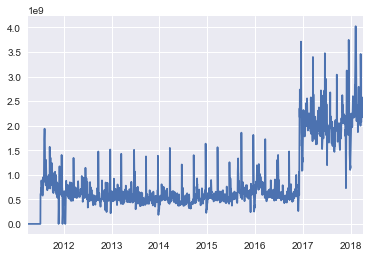

In [6]:
data['Volume'].plot();                                    # Check 0 Volumes

In [7]:
# Discard days with 0 Volumn & check again
Day_Volume  = data[data['Volume'] == 0].index[-1] + day
print 'Cleaned data with Volume start from: ' + str(Day_Volume)
data_Volume = data[Day_Volume:]
display(data_Volume.describe())

Cleaned data with Volume start from: 2012-01-15


,Open,High,Low,Close,Volume
count,1562.000000,1562.000000,1562.000000,1562.000000,1.562000e+03
mean,1960.789334,1969.250282,1951.774206,1962.883419,8.968734e+08
std,379.863028,380.431132,378.942961,376.492956,6.668476e+08
min,0.000000,0.000000,0.000000,1278.040000,1.839316e+08
25%,1666.997500,1677.495000,1659.162500,1672.537500,4.980727e+08
50%,2001.435000,2015.960000,1991.240000,2001.665000,5.780853e+08
75%,2163.205000,2168.830000,2152.542500,2163.727500,8.532459e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


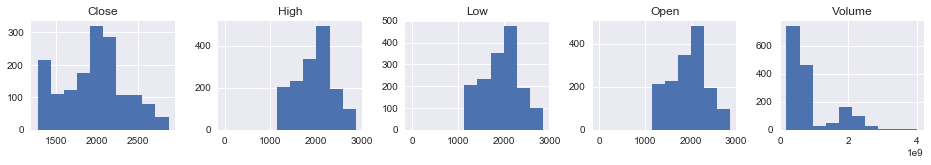

In [8]:
data_Volume.hist(figsize = (16, 2), layout = (1, 5));     # Check distribution

In [9]:
for c in ['Open', 'High', 'Low']:
    display(data_Volume[data_Volume[ c    ] < 1000]) # Check prices < 1000 (the strange gap in 'Open', 'High', and 'Low')

,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
count,1561.000000,1561.000000,1561.000000,1561.000000,1.561000e+03
mean,1962.045445,1970.511813,1953.024542,1962.558360,8.960452e+08
std,376.725750,377.270678,375.827508,376.394285,6.662573e+08
min,1277.820000,1282.550000,1266.740000,1278.040000,1.839316e+08
25%,1669.390000,1679.610000,1660.880000,1671.710000,4.980639e+08
50%,2001.670000,2015.980000,1991.470000,2001.570000,5.778871e+08
75%,2163.370000,2168.990000,2152.560000,2163.660000,8.523355e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


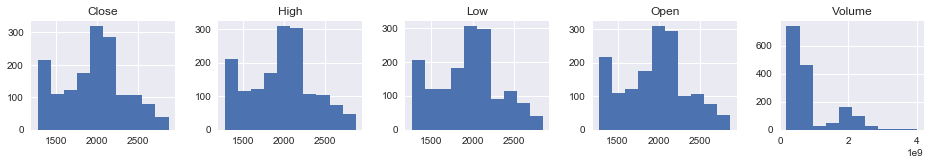

In [10]:
data_Volume_Price     = data_Volume[
                        data_Volume['Open'] > 1000] # Discard the abnormal day
data_Volume_Price     . hist(figsize = (16, 2), layout = (1, 5));
display               ( data_Volume_Price.describe())
data_clean            = data_Volume_Price

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many days fit into either group, and will tell us about the percentage of these daily prices uping or falling. In the code cell below, we will compute the basic following and additional statistics with [stockstats](https://pypi.python.org/pypi/stockstats):
- The total number of records, `'n_records'`.
- The number of the next daily prices upping, `'n_up'`.
- The number of the next daily prices downing, `'n_down'`.
- The number of the next daily prices flatting, `'n_flat'`.
- The percentage of the next daily prices upping, `'up_percent'`.

In [11]:
col_pre    = ['Open'     , 'Close'     ]  # Collect previous daily data column
col_next   = ['Open'     , 'Close'     ]  # Collect next     daily data column
# d          = concat([data_clean, data_clean[col_next].shift(-1).rename(columns = lambda c: c + '_next')])[:-1]
d          = concat([   data_clean[col_pre ].shift( 1).rename(columns = lambda c: c + '_pre' ), data_clean]) # Acronyms of data
d          = concat([d, data_clean[col_next].shift(-1).rename(columns = lambda c: c + '_next')            ])[1:-1] # Discard the 1st/last one which lacks a previous/next daily data

y_rgr_col  = list  ( d            .columns[ -len (col_next):])  # Select data column for regression y
X_col      = list  (    data_clean.columns)                     # Select data column for            X

for                    p1,     p2 in   [
             ('Open_pre'             ,         'Close'                           ), # Vector from Open_pre  to Close
             (            'Close_pre',         'Close'                           ), # Vector from Close_pre to Close
             (                         'Open', 'Close'                           ), # Vector from Open      to Close
             (                         'Open',          'Open_next'              ), # Vector from Open      to  Open_next
             (                                 'Close', 'Open_next'              ), # Vector from Close     to  Open_next
             (                                 'Close',              'Close_next'), # Vector from Close     to Close_next
             (                                          'Open_next', 'Close_next'), # Vector from Open_next to Close_next
             ]:
    p      = '_'.join([p1,     p2      ])
    d [p]  =       - d[p1] + d[p2]
    if p.find('next') < 0:                                                          # next daily data are usually for y
        X_col.append(  p )

y_clf_vec  = ['Close_Close_next', 'Open_Open_next', 'Close_Open_next', 'Open_next_Close_next'] # Vectors for classification y
y_clf_col  = []
for   vec    in y_clf_vec:                # Index of records where the next daily prices up
    col    =          vec + '_up'         # Merge 'flat' to 'up': Align to the 'up' of matplotlib.finance
    d[col] =  0 <=  d[vec]
    y_clf_col.append  (col)
Xy_col     = [c for c in d.columns if 0 <= c.find('Open_next') and c.find('Close_next') < 0  ] # X sometimes includes Open_next

Close_Close_next_flat     =         0   == d.    Close_Close_next
Close_Open_next_flat      =         0   == d.     Close_Open_next

n_records                 = d.shape[0]                                # Total number of records
n_up                      = sum    (       d.Close_Close_next_up    )
n_flat                    = sum    (         Close_Close_next_flat  )
n_down                    = sum    (0    > d.Close_Close_next       )
up_percent                = float  (n_up)/n_records*100               # Percentage of days whose price up

print '[Example Daily Close-to-Close (Close_Close_next) prices]'
print 'Total number of records: {}'               .format(n_records )
print 'Daily prices upping:     {}  ({})'         .format(n_up      , 'Close_Close_next_up, including flatting to align the "up" of matplotlib.finance')
print 'Daily prices flatting:   {}'               .format(n_flat    )
print 'Daily prices downing:    {}'               .format(n_down    )
print 'Percentage of daily prices upping: {:.2f}%'.format(up_percent)

print '\nThe flat days with the same         Close     prices'
display       ( d[Close_Close_next_flat | Close_Close_next_flat.shift(1)])
print '\nThe flat day  with the same Open  & Close     prices'
display       ( d[    d.Open           ==     d.Close                   ])
# print '\n     {} days with the same Close & Open_next prices'.format(sum(Close_Open_next_flat))
# display       ( d[ Close_Open_next_flat |  Close_Open_next_flat.shift(1)].head(n = 2))

[Example Daily Close-to-Close (Close_Close_next) prices]
Total number of records: 1559
Daily prices upping:     842  (Close_Close_next_up, including flatting to align the "up" of matplotlib.finance)
Daily prices flatting:   1
Daily prices downing:    717
Percentage of daily prices upping: 54.01%

The flat days with the same         Close     prices


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,Close_pre_Close,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up
2017-01-10,2271.14,2276.98,2273.59,2275.49,2268.90,2268.9,1914652521,2269.72,2268.90,-2.24,-8.08,-4.69,-3.87,0.82,0.00,-0.82,True,False,True,False
2017-01-11,2273.59,2268.90,2269.72,2279.27,2265.27,2268.9,2138024556,2268.60,2275.32,-4.69,0.00,-0.82,-1.12,-0.30,6.42,6.72,True,False,False,True



The flat day  with the same Open  & Close     prices


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,Close_pre_Close,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,Close_Close_next_up,Open_Open_next_up,Close_Open_next_up,Open_next_Close_next_up
2017-04-11,2356.59,2355.54,2357.16,2366.37,2351.5,2357.16,1620328913,2353.92,2353.78,0.57,1.62,0.0,-3.24,-3.24,-3.38,-0.14,False,False,False,False


** Featureset Exploration **

All features are continuous

In [12]:
hdr_reg  =  'Regular Features'                             # Headers
hdr_opt  = 'Optional Features (when y excludes Open_next)' #
def XXy_display      ( d,     X_col           ,      Xy_col       ):
    XXy  =  pd.concat([d[     X_col          ], d[   Xy_col      ]], keys =
                      [     hdr_reg           ,     hdr_opt       ], axis = 1)
    display(XXy.tail())
    return  XXy
def y_display        ( d, y_clf_col           ,   y_rgr_col       ):
    y    =  pd.concat([d[ y_clf_col          ], d[y_rgr_col      ]], keys =
                      [  'y (Classifications)',  'y (Regressions)'], axis = 1)
    display(  y.tail())
    return    y

XXy_display(           d,     X_col           ,      Xy_col       )
y_display  (           d, y_clf_col           ,   y_rgr_col       )
display    (           d[ y_clf_vec          ].rename(columns = lambda c: ('Vectors for Classification', c)).tail())

Regular Features                                         \
                       Open     High      Low    Close      Volume   
2018-03-27          2619.35  2661.36  2601.81  2658.55  2434497989   
2018-03-28          2667.57  2674.78  2596.12  2612.62  2501316081   
2018-03-29          2611.30  2632.65  2593.06  2605.00  2574191549   
2018-03-30          2614.41  2659.07  2609.72  2640.87  2348028811   
2018-04-03          2633.45  2638.30  2553.80  2581.88  2468994069   

                                                      \
           Open_pre_Close Close_pre_Close Open_Close   
2018-03-27          11.84           70.29      39.20   
2018-03-28          -6.73          -45.93     -54.95   
2018-03-29         -62.57           -7.62      -6.30   
2018-03-30          29.57           35.87      26.46   
2018-04-03         -32.53          -58.99     -51.57   

           Optional Features (when y excludes Open_next)                 \
                                               Open_next Open_Open_next   
2018-03-27                                       2667.57          48.22   
2018-03-28                                       2611.30         -56.27   
2018-03-29                                       2614.41           3.11   
2018-03-30                                       2633.45          19.04   
2018-04-03                                       2592.17         -41.28   

                                                                 
           Close_Open_next Open_Open_next_up Close_Open_next_up  
2018-03-27            9.02              True               True  
2018-03-28           -1.32             False              False  
2018-03-29            9.41              True               True  
2018-03-30           -7.42              True              False  
2018-04-03           10.29             False               True

y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2018-03-27               False              True               True   
2018-03-28               False             False              False   
2018-03-29                True              True               True   
2018-03-30               False              True              False   
2018-04-03                True             False               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2018-03-27                   False         2667.57    2612.62  
2018-03-28                   False         2611.30    2605.00  
2018-03-29                    True         2614.41    2640.87  
2018-03-30                   False         2633.45    2581.88  
2018-04-03                    True         2592.17    2614.45

Vectors for Classification                                 \
                     Close_Close_next Open_Open_next Close_Open_next   
2018-03-27                     -45.93          48.22            9.02   
2018-03-28                      -7.62         -56.27           -1.32   
2018-03-29                      35.87           3.11            9.41   
2018-03-30                     -58.99          19.04           -7.42   
2018-04-03                      32.57         -41.28           10.29   

                                 
           Open_next_Close_next  
2018-03-27               -54.95  
2018-03-28                -6.30  
2018-03-29                26.46  
2018-03-30               -51.57  
2018-04-03                22.28

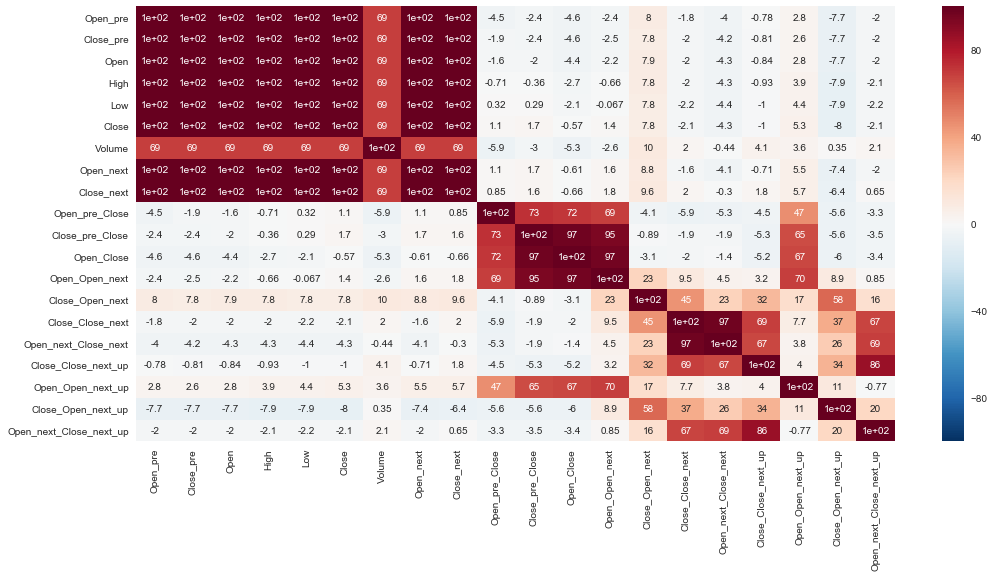

In [13]:
def corr_heatmap(data):
    corr = 100*  data.corr()
    _, _ = plt.subplots(figsize   = (Page_size, Page_size/2))
    sns.heatmap (     corr, annot = True);
corr_heatmap(d)

In [14]:
from stockstats import StockDataFrame
# from copy       import deepcopy
# s_copy  =              deepcopy(d     )
# s       = StockDataFrame.retype(s_copy)          # The data => StockDataFrame
s       = StockDataFrame.retype(d.copy())          # The data => StockDataFrame
stats   = ['volume_delta', 'open_-2_r', 'cr', 'cr-ma1', 'cr-ma2', 'cr-ma3', 'volume_-3,2,-1_max', 'volume_-3~1_min',
           'kdjk', 'kdjd', 'kdjj', 'open_2_sma', 'macd', 'macds', 'macdh', 'boll', 'boll_ub', 'boll_lb', 'cr-ma2_xu_cr-ma1_20_c',
           'rsi_6', 'rsi_12', 'wr_10', 'wr_6', 'cci', 'cci_20', 'tr', 'atr', 'dma', 'pdi', 'mdi', 'dx', 'adx', 'adxr',
           'trix', 'trix_9_sma', 'vr', 'vr_6_sma'] # Examples from the Tutorial of the stockstats

In [15]:
# [ s[stat] for stat in  stats]                    # Generate relative statistics
for             stat in  stats:                    # Generate relative statistics
    s[stat]                                        # The SettingWithCopyWarning might in stockstats.StockDataFrame

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
def display_n     (data, right = '',  corr = False,
                                      n    = 5):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display  ((data.loc[:, right:] if right else data).describe())
        if  corr:
            print '\nTop {} Positive/Negative Correlation with {} of Statistics'  .                         format(n, corr)
            corr =(data    .corr()[corr].sort_values(by = corr, ascending = False)*100).applymap('{:6.2f}%'.format)
            display(concat([corr.head(n   = n)      .reset_index().rename(columns = {'index': 'Positive'}),
                            corr.tail(n   = n)[::-1].reset_index().rename(columns = {'index': 'Negitive'})])
                                                                  .rename(index   = lambda i: i + 1))
            
_max = lambda s: max([int(n) for n in s.split('_') if n.isdigit()] or [1])

print 'Some raw and side statistics examples of the stockstats might incomplete in the first few days:'
display_n  ( s, stats[0])                          # display only new features

print '\nThe statistics with the most day number of data:'
stats_days = pd.DataFrame([(c, _max(c)) for c in s.columns],              columns = ['Statistics', 'Days']
                                                            ).sort_values(by      =                'Days', ascending = False
                                                            ).reset_index(drop    = 1
                                                            )     .rename(index   = lambda i: i + 1)
display                 (stats_days.head())
stats_day  =         max(stats_days.Days  )
s_cplt     = s     .iloc[stats_day:-  stats_day                      ]
s_cplt     = s_cplt. loc[         :, (s_cplt  != s_cplt.iloc[0]).any()]
print 'Dropped the first, last {} days and constant statistics are dropped to complete integrity'.format(stats_day)

Some raw and side statistics examples of the stockstats might incomplete in the first few days:


,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,cr-ma1_20_c,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.558000e+03,1557.000000,1559.000000,1558.000000,1554.000000,1552.000000,1548.000000,1.556000e+03,1.558000e+03,1.557000e+03,1.559000e+03,1.557000e+03,1.559000e+03,1.558000e+03,1.559000e+03,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1558.000000,1559.000000,1558.000000,1558.000000,1535.0,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1559.000000,1559.000000,1559.000000,1558.000000,1559.000000,1558.000000,1558.000000,1558.000000,1559.000000,1559.00000,1559.000000,1558.000000,1558.000000,1558.000000,1558.000000,1559.000000,1559.000000,1559.000000,1558.000000,1558.000000,1558.000000,1559.000000,1559.000000,1559.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1555.000000
mean,1.150927e+06,0.095901,1962.047868,inf,124.273422,124.570895,125.080282,8.923675e+08,8.943813e+08,8.956812e+08,1.032854e+09,8.934477e+08,8.953913e+08,8.955322e+08,7.603889e+08,63.219417,63.257387,63.257387,63.293625,63.293625,63.184913,63.184913,1961.642495,1951.670081,6.188356,6.238714,-0.100717,1954.329881,22.909637,1954.329881,2000.563975,1908.925428,20.0,1962.171759,0.817612,inf,57.025252,inf,56.452048,36.378849,38.086502,1956.474739,27.427879,1953.762438,32.456566,18.457375,18.146116,1958.789141,1940.96786,17.821280,0.853780,4.634596,0.810533,4.688023,4.491572,4.475972,4.475972,18.146116,25.290678,25.290678,4.591167,4.513963,4.513963,23.133653,23.133653,31.676433,31.676433,31.751359,31.751359,31.835416,31.835416,0.046981,0.047381,0.046754,inf,125.198924
std,2.636948e+08,1.069127,375.963158,NaN,48.709227,46.407053,41.728978,6.629254e+08,6.648903e+08,6.662508e+08,7.467151e+08,6.640816e+08,6.658722e+08,6.660627e+08,5.697396e+08,30.707117,23.327225,23.327225,20.287907,20.287907,36.490617,36.490617,376.171462,372.913878,13.148884,11.969582,9.472479,374.254355,13.206552,374.254355,380.944280,368.852877,0.0,375.684501,15.548785,NaN,17.493245,NaN,12.129312,30.584558,31.133499,375.059009,105.978256,374.346390,108.504575,12.221672,6.778838,375.332487,370.35230,37.376327,11.858161,7.114988,14.857902,9.963471,7.151010,2.162228,2.162228,6.778838,9.474594,9.474594,9.982937,3.837524,3.837524,11.733767,11.733767,21.170098,21.170098,15.419122,15.419122,13.510757,13.510757,0.106945,0.102674,0.786850,NaN,52.088467
min,-1.854808e+09,-6.911553,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1308.040000,-47.639949,-40.305676,-61.144555,1308.040000,3.228371,1308.040000,1320.170742,1270.300916,20.0,1278.040000,-113.190000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1302.380000,-340.578134,1302.380000,-395.599439,3.700000,6.807037,1305.426000,1308.04000,-125.243000,-72.360000,0.000000,-121.800000,0.000000,0.000000,0.000000,0.000000,6.807037,4.532342,4.532342,0.000000,0.000000,0.000000,0.000000,0.000000,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-4.097924,34.691762,46.627682
25%,-6.629597e+07,-0.412007,1669.303333,89.023659,91.205184,91.916426,94.855472,4.979677e+08,4.980131e+08,4.979962e+08,5.640408e+08,4.979962e+08


The statistics with the most day number of data:


,Statistics,Days
1,close_50_sma,50
2,close_26_ema,26
3,close_20_mstd,20
4,close_20_sma,20
5,cr-ma1_20_c,20


Dropped the first, last 50 days and constant statistics are dropped to complete integrity


In [17]:
display_n(s_cplt, right = stats[0], corr = ['close_close_next_up', 'close_close_next'], n = 10)

,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.459000e+03,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,1.147790e+06,0.098715,1956.539168,122.117574,121.544414,121.306494,120.959335,8.473048e+08,8.499836e+08,8.533502e+08,9.836474e+08,8.487053e+08,8.511314e+08,8.523785e+08,7.203187e+08,63.096708,63.074073,63.074073,63.057220,63.057220,63.107781,63.107781,1956.011823,1945.686277,6.299883,6.243411,0.112944,1948.302492,22.111010,1948.302492,1992.524512,1904.080472,1956.152838,0.954414,1.816013,56.853937,1.459085,56.166658,36.533676,38.082846,1950.468528,26.670906,1947.736620,31.771543,17.747533,17.699079,1952.870490,1934.918412,17.952078,0.954202,4.510576,0.956381,4.360192,4.374291,4.355230,4.355230,17.699079,25.075363,25.075363,4.274297,4.285181,4.285181,23.054271,23.054271,31.069227,31.069227,30.994995,30.994995,30.946161,30.946161,0.046091,0.046035,0.050115,122.991812,122.944137
std,2.578841e+08,1.036524,343.821511,47.201029,43.523514,40.508091,35.064363,6.108945e+08,6.138976e+08,6.173777e+08,6.901109e+08,6.125682e+08,6.150555e+08,6.164308e+08,5.242386e+08,30.740634,23.331490,23.331490,20.319873,20.319873,36.474535,36.474535,343.568847,338.924031,12.816060,11.766085,8.754642,339.919961,11.433627,339.919961,341.203064,340.172678,343.525425,14.420607,1.473774,17.278609,0.716534,11.690794,30.632302,31.104456,340.918035,105.903456,339.891973,108.427579,10.374519,5.606312,341.761455,335.907116,36.659605,11.179047,6.874028,13.372562,8.587522,6.909601,1.987813,1.987813,5.606312,9.323214,9.323214,8.607868,3.086662,3.086662,11.110929,11.110929,20.605308,20.605308,14.565010,14.565010,12.291112,12.291112,0.106711,0.102843,0.763381,53.599874,51.180876
min,-1.854808e+09,-6.686069,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1324.033020,-47.639949,-40.305676,-47.470134,1310.821000,5.550314,1310.821000,1341.444192,1270.300916,1278.040000,-77.680000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1306.971190,-340.578134,1310.760500,-395.599439,3.700000,9.318114,1305.426000,1332.767800,-125.243000,-72.360000,0.000000,-103.880000,0.000000,0.000000,0.922930,0.922930,9.318114,4.532342,4.532342,0.000000,0.257627,0.257627,2.451626,2.451626,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-3.941367,34.691762,46.627682
25%,-6.395280e+07,-0.404201,1690.036667,89.369795,91.151549,91.818978,94.261556,4.937561e+08,4.937561e+08,4.937561e+08,5.591816e+


Top 10 Positive/Negative Correlation with ['close_close_next_up', 'close_close_next'] of Statistics


,Positive,close_close_next_up,close_close_next,Negitive,close_close_next_up,close_close_next
1,close_close_next_up,100.00%,71.50%,rsi_12,-5.79%,-6.81%
2,open_next_close_next_up,86.21%,69.67%,open_close,-5.56%,-1.63%
3,close_close_next,71.50%,100.00%,rsi_6,-5.53%,-6.53%
4,open_next_close_next,69.39%,97.80%,close_-1_d,-5.48%,-1.88%
5,close_open_next,36.77%,48.26%,close_pre_close,-5.48%,-1.88%
6,close_open_next_up,35.62%,40.67%,rsv_9,-5.45%,-6.44%
7,wr_10,5.35%,6.69%,rs_12,-5.39%,-4.76%
8,wr_6,5.34%,6.47%,rs_6,-5.36%,-3.74%
9,volume,5.32%,5.49%,change,-5.00%,-1.58%
10,volume_0_s,5.32%,5.49%,cci_20,-4.83%,-5.90%


In [18]:
X_stat_col, days_max = [], 0
for    col          ,   stat     in [
     ('RSI12'       ,  'rsi_12'     ),          # 12 days Relative Strength Index (RSI)
     ('RSI6'        ,  'rsi_6'      ),          #  6 days Relative Strength Index (RSI)
     ('WR10'        ,  'wr_10'      ),          # 
     ('WR6'         ,  'wr_6'       ),          # 
     ('C2M'         ,  'close_2_sma'),          #  2 days simple moving average (rolling means) on close price
     ('MACD'        ,  'macd'       ),          # Moving Average Convergence Divergence (MACD)
     ('Boll_u'      ,  'boll_ub'    ),          # Bollinger Upper Bands
     ('Boll'        ,  'boll'       ),          # Bollinger       Bands
     ('Boll_l'      ,  'boll_lb'    ),          # Bollinger Lower Bands
                                    ]:
    d[ col      ]   = s[stat        ]
    X_stat_col.append  ( col)
    days_cur     = _max(stat)
    if  days_max <  days_cur:
        days_max =  days_cur
        stat_max =      stat
        col_max  =       col
X_col   += X_stat_col
display(   d.loc[        :,  X_stat_col[0] :].head(n = days_max))
data_raw = d    [days_max:                  ]
print 'The first {} days w/o sufficient data for {}-day {} be dropped'.format(days_max - 1, days_max, stat_max)
display(   d.loc[        :,         col_max:].tail(n = days_max))

,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2012-01-19,NaN,NaN,0.408879,0.408879,1308.040,0.000000,NaN,1308.040000,NaN
2012-01-20,100.000000,100.000000,4.040816,4.040816,1311.270,0.144936,1320.405820,1311.270000,1302.134180
2012-01-21,100.000000,100.000000,0.448980,0.448980,1314.940,0.211966,1320.655884,1312.640000,1304.624116
2012-01-24,100.000000,100.000000,20.070310,20.070310,1315.690,0.259643,1320.837028,1313.480000,1306.122972
2012-01-25,82.315081,78.282565,24.384787,24.384787,1315.325,0.226364,1320.170742,1313.714000,1307.257258
2012-01-26,93.277192,93.218876,6.003752,6.003752,1320.355,0.690002,1327.389215,1315.771667,1304.154118
2012-01-27,64.232195,60.067847,35.404896,54.870485,1322.245,0.629801,1326.945454,1316.151429,1305.357403
2012-01-28,58.740379,53.754183,40.348399,62.531923,1317.380,0.479432,1326.167874,1316.173750,1306.179626
2012-01-31,51.191713,44.817317,48.163842,62.037599,1314.670,0.203292,1325.405843,1315.822222,1306.238602
2012-02-01,49.926777,43.257655,49.576271,63.856883,1312.710,-0.026457,1324.770671,1315.481000,1306.191329


The first 11 days w/o sufficient data for 12-day rsi_12 be dropped


,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-16,52.197774,50.801950,35.302109,68.858044,2748.405,8.295025,2793.936386,2734.2720,2674.607614
2018-03-17,53.181479,53.461513,39.548157,82.558332,2749.670,8.255960,2795.475055,2735.3125,2675.149945
2018-03-20,44.784013,34.674054,82.918647,82.918647,2732.465,5.012979,2795.332430,2734.3475,2673.362570
2018-03-21,45.745129,37.389347,79.172491,79.172491,2714.930,2.735737,2795.324714,2734.3815,2673.438286
2018-03-22,44.687586,35.201177,83.841208,78.986912,2714.435,0.520738,2794.820041,2734.9115,2675.002959
2018-03-23,33.261751,17.991290,98.690038,98.270751,2677.810,-6.664241,2803.319140,2731.8980,2660.476860
2018-03-24,27.117775,12.184685,98.902829,98.653103,2615.975,-16.639318,2819.488351,2723.9460,2628.403649
2018-03-27,41.951022,41.107915,66.362668,53.270307,2623.405,-18.657749,2813.926644,2717.8935,2621.860356
2018-03-28,36.635903,32.670391,86.021337,82.557912,2635.585,-23.690448,2817.265582,2711.3105,2605.355418
2018-03-29,35.814648,31.387795,89.211923,87.530179,2608.810,-27.971332,2821.971635,2705.8690,2589.766365


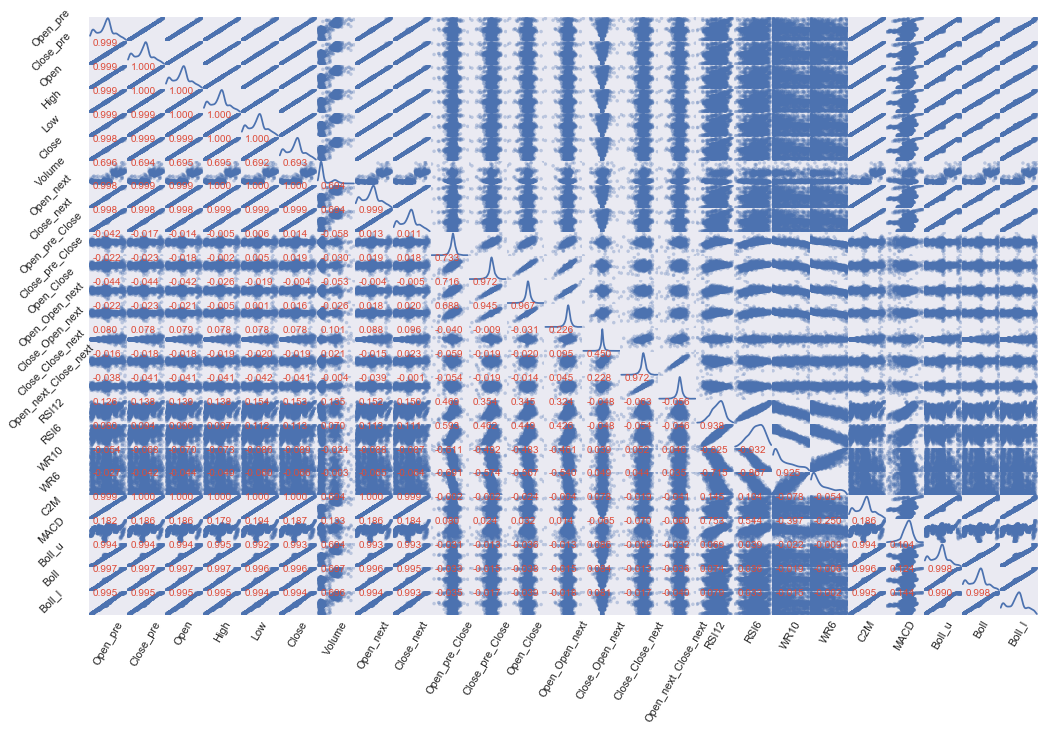

In [19]:
# print 'Produce a scatter matrix for each pair of features in the data'
data_corr = data_raw[[c for c in d.columns if c.find('up') < 0]]
mtrx_corr = data_corr.corr().as_matrix()
axs       = pd.plotting.scatter_matrix(data_corr, alpha = 0.3, figsize = (Page_size, Page_size*2/3), diagonal = 'kde')
for          i, j in  zip (*np.tril_indices_from(axs, k = 0)):
    ax = axs[i, j]
    if       i!=j:
        ax.annotate('%.3f' %mtrx_corr[i, j], ( 0.1, 0.8), xycoords = 'axes fraction', color = R)
    ax.get_yaxis().set_label_coords          (-0.9, 0.4)
    ax.xaxis.label.set_rotation(60)
    ax.yaxis.label.set_rotation(45)
    ax.set_xticks(())
    ax.set_yticks(())

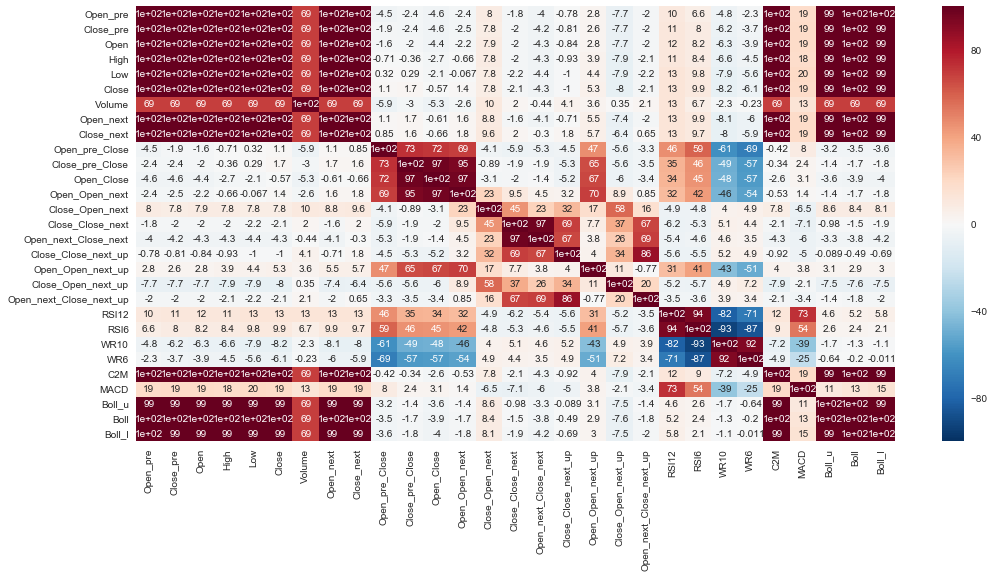

In [20]:
corr_heatmap(d)

In [21]:
display_n(d, corr = ['Close_Close_next_up', 'Close_Close_next'], n = 10)

,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,Close_pre_Close,Open_Close,Open_Open_next,Close_Open_next,Close_Close_next,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1.559000e+03,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1558.000000,1558.000000,1559.000000,1559.000000,1559.000000,1559.000000,1558.000000,1559.000000,1558.000000
mean,1961.210597,1961.742957,1962.072194,1970.523926,1953.050417,1962.569262,8.953913e+08,1962.905112,1963.407242,1.358666,0.826305,0.497069,0.832919,0.335850,0.837979,0.502130,56.452048,57.025252,36.378849,38.086502,1962.160718,6.188356,2000.563975,1954.329881,1908.925428
std,376.244061,375.945353,376.244504,376.775596,375.362450,375.891727,6.658722e+08,376.201131,375.887838,20.900146,15.547583,14.271764,14.642687,3.747897,15.564583,14.278092,12.129312,17.493245,30.584558,31.133499,375.830083,13.148884,380.944280,374.254355,368.852877
min,1277.820000,1278.040000,1277.820000,1282.550000,1266.740000,1278.040000,1.839316e+08,1277.820000,1278.040000,-159.980000,-113.190000,-104.010000,-126.280000,-34.160000,-113.190000,-104.010000,14.858333,6.337629,0.000000,0.000000,1278.110000,-47.639949,1320.170742,1308.040000,1270.300916
25%,1667.795000,1670.435000,1671.855000,1679.900000,1661.775000,1673.365000,4.980300e+08,1674.790000,1675.570000,-8.095000,-5.750000,-5.615000,-5.685000,-0.815000,-5.750000,-5.615000,48.084877,45.015571,8.475935,9.586457,1670.540000,-0.617244,1709.323513,1659.888250,1615.806806
50%,2001.200000,2001.540000,2001.670000,2015.980000,1991.470000,2001.570000,5.778148e+08,2002.450000,2001.760000,2.210000,0.870000,0.900000,1.400000,0.020000,0.870000,0.900000,57.631522,58.432944,29.109762,31.001171,2002.825000,7.734790,2074.576529,1994.273000,1941.449760
75%,2162.375000,2163.190000,2163.040000,2168.670000,2152.525000,2163.460000,8.520512e+08,2163.440000,2163.705000,12.280000,8.780000,7.800000,8.350000,1.625000,8.780000,7.800000,65.114027,70.634657,59.825464,63.480068,2160.830000,14.589905,2192.224963,2152.950000,2117.508149
max,2867.230000,2872.870000,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09,2867.230000,2872.870000,114.910000,72.890000,80.360000,76.170000,31.090000,72.890000,80.360000,100.000000,100.000000,100.000000,100.000000,2863.200000,47.662717,2945.158618,2801.856500,2722.922774



Top 10 Positive/Negative Correlation with ['Close_Close_next_up', 'Close_Close_next'] of Statistics


,Positive,Close_Close_next_up,Close_Close_next,Negitive,Close_Close_next_up,Close_Close_next
1,Close_Close_next_up,100.00%,69.09%,RSI12,-5.64%,-6.15%
2,Open_next_Close_next_up,86.19%,67.36%,RSI6,-5.48%,-5.34%
3,Close_Close_next,69.09%,100.00%,Close_pre_Close,-5.34%,-1.93%
4,Open_next_Close_next,66.90%,97.21%,Open_Close,-5.17%,-2.03%
5,Close_Open_next_up,34.42%,37.29%,MACD,-5.02%,-7.07%
6,Close_Open_next,32.04%,44.95%,Open_pre_Close,-4.51%,-5.85%
7,WR10,5.24%,5.13%,Close,-1.03%,-2.10%
8,WR6,4.87%,4.38%,Low,-1.00%,-2.16%
9,Volume,4.05%,2.03%,High,-0.93%,-2.03%
10,Open_Open_next_up,3.98%,7.71%,C2M,-0.92%,-2.06%


Test Data


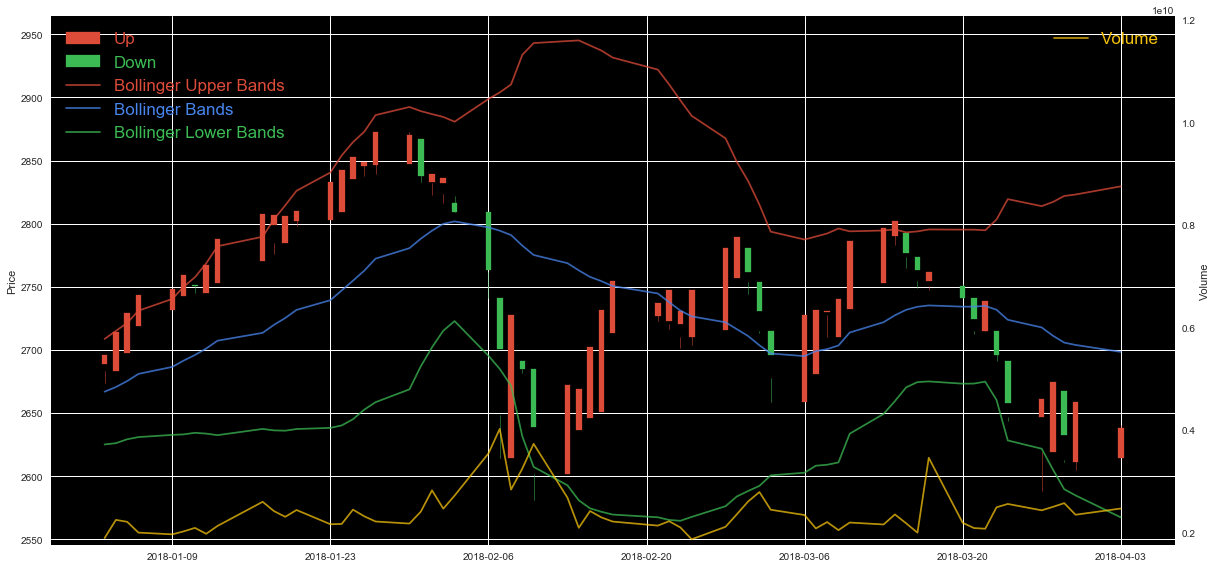

All Data


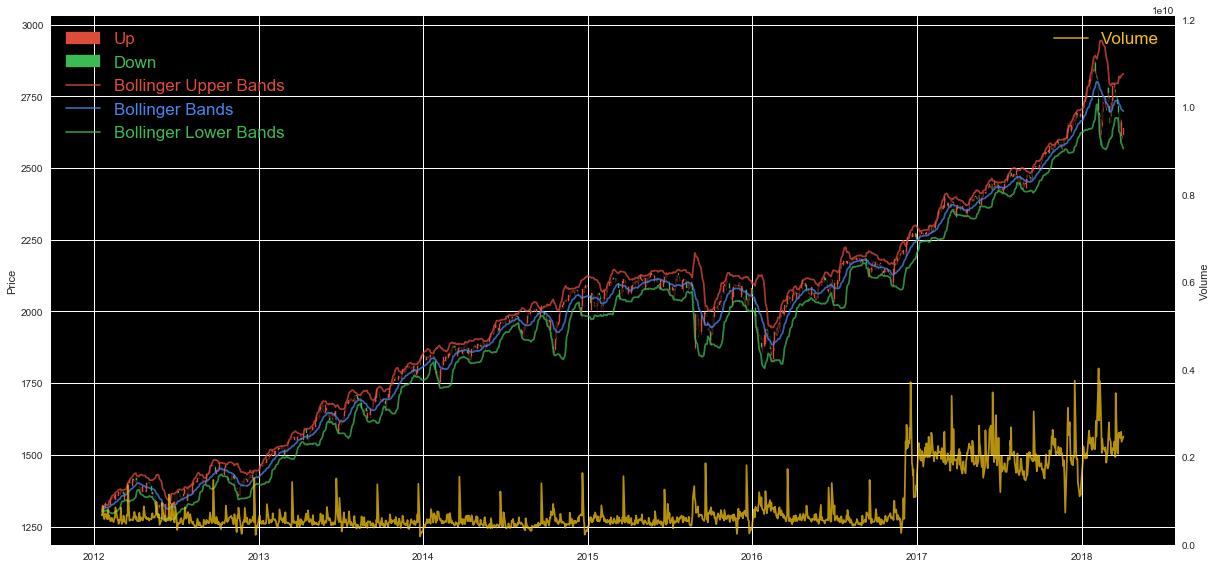

In [22]:
# Candle Stick Plot of open, high, low, close and Volume
from matplotlib.finance import candlestick_ohlc #, volume_overlay3
from matplotlib.patches import Patch

def FigStock(    x, size = 16, boll = False):
    x=           x. reset_index()
    x['index'] = x      ['index'].apply (dates.  date2num)
    fig, axP   = plt.subplots(figsize = (size , size/2  ))
    candlestick_ohlc(axP, x.values,    colorup = R ,   colordown = G, width = .5)
    axP. set_facecolor  ('#000000')
    axP.xaxis_date()
    axP. set_prop_cycle (  'color' ,      [      R ,  B    ,       G ])
    if  boll:
        boll = axP.plot (x['index'],    x[['Boll_u', 'Boll', 'Boll_l']].values, alpha = 0.75)
    axV      = axP.twinx()
    axV           .plot (x['index'],    x[ 'Volume'                   ].values, alpha = 0.75, label = 'Volume', color = Y)
    axV.grid      (False)
    axV.set_ylim  (None            ,  3*x[ 'Volume'].max())
    axV.set_ylabel(                        'Volume')
    axP.set_ylabel(                        'Price' )
    axV                   .legend( prop   = {'size': size}, loc = 'best'         ).get_texts()[0].set_color(Y)
    for text, c in zip(axP.legend([Patch(color = R), Patch(color = G)] +   boll,
                                  [            'Up',              'Down', 'Bollinger Upper Bands' ,
                                                                          'Bollinger Bands'       ,
                                                                          'Bollinger Lower Bands'],
                                   prop   = {'size': size}, loc = 'upper left'   ).get_texts()    ,
                                  [              R ,               G,      R, B, G]):
        text.set_color(c)
    plt.tight_layout()
    return axP, x

print 'Test Data'
FigStock(d[date_split:], Page_size, boll = True);
plt.show()
print  'All Data'
FigStock(d             , Page_size, boll = True);

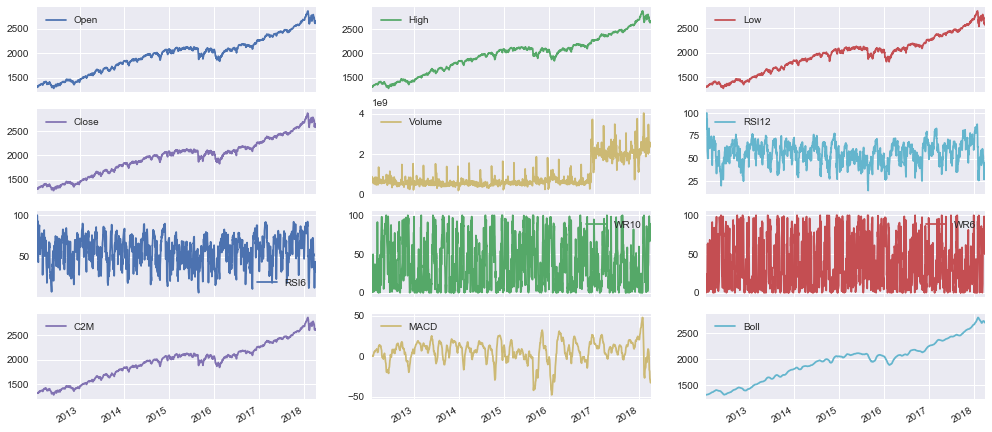

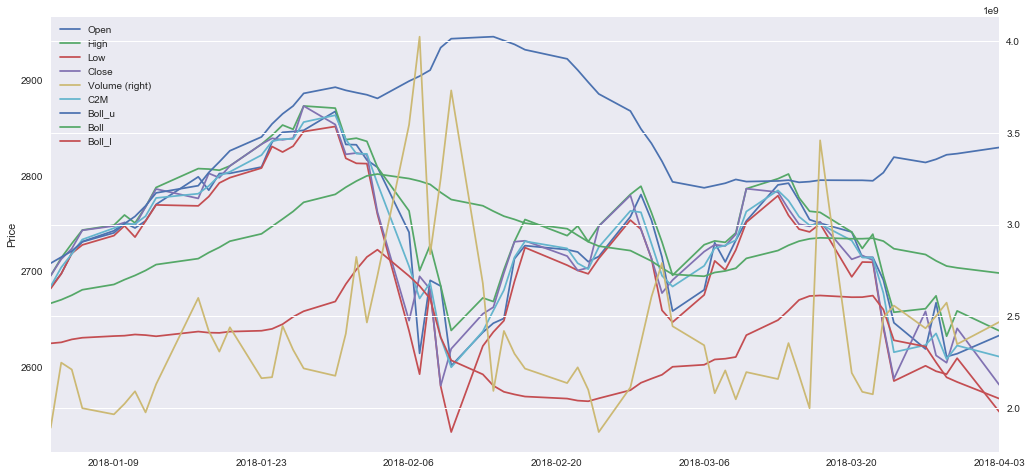

In [23]:
d_plot = d.drop([c for c in d.columns if 1 < len(c.split('_'   ))]                                 , axis = 1)
d_plot                       .plot(figsize  =   (Page_size, Page_size/2), subplots    = True, layout = (4, 3));
d_plot = d.drop([c for c in d.columns if 0 <=    c.find ('pre' )  +
                                                 c.find ('next')] + ['Open_Close', 'RSI6', 'RSI12', 'WR6', 'WR10', 'MACD'], axis = 1)
#                                                  c.find ('next')] + ['Open_Close', 'RSI6', 'WR6', 'MACD'], axis = 1)
ax     = d_plot [date_split:].plot(figsize  =   (Page_size, Page_size/2), secondary_y = 'Volume');
ax     . set_ylabel('Price');

----
## Preparing the Data
### Normalizing Numerical Features
We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) first and try others later.

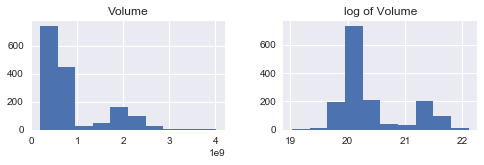

In [24]:
# Try Log-transform for the special feature
log           = ['Volume']
data_log      = data_raw     .copy  ()
data_log[log] = data_log[log].apply (          lambda x: np.log(x  + 1))
concat( [       data_raw[log],
                data_log[log].rename(columns = lambda c: 'log of ' + c)]).hist(figsize = (8, 2));

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
numerical = [c for c in data_raw.columns if c.find('up') < 0]
for data_scale, name in ((data_raw, 'data_raw'), (data_log, 'data_log'),):
# for data_scale, name in ((data_log, 'data_log'), (data_raw, 'data_raw'),):
    for scaler in (  RobustScaler(), StandardScaler(), MinMaxScaler(),):
#     for scaler in (StandardScaler(),   MinMaxScaler(), RobustScaler(),):
        data_scaled                  =                           data_scale .copy()
        data_scaled[numerical]       =      scaler.fit_transform(data_scaled[numerical])
        print '\n[{} with {}]'.format(name, ClassName(scaler))
#         display(data_scaled.head(n = 5)) # Show examples of records with scaling applied
        display(data_scaled.tail(n = 5))
        display(data_scaled.describe())


[data_raw with RobustScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-27,1.331607,1.218061,1.273836,1.337816,1.270954,1.364731,5.196938,1.374327,1.270364,0.470244,...,False,-0.914409,-0.673717,0.721463,0.407203,1.288536,-1.733192,1.546862,1.492236,1.350010
2018-03-28,1.274914,1.364254,1.373823,1.365750,1.259070,1.269059,5.383861,1.257512,1.254467,-0.435610,...,False,-1.225531,-1.003492,1.103966,0.948260,1.313957,-2.062417,1.553871,1.478608,1.316929
2018-03-29,1.374830,1.268726,1.257143,1.278054,1.252679,1.253187,5.587729,1.263969,1.329300,-3.159512,...,True,-1.273604,-1.053622,1.166046,1.040118,1.258073,-2.342461,1.563749,1.467343,1.285683
2018-03-30,1.258234,1.252878,1.263592,1.333049,1.287475,1.327904,4.955042,1.303495,1.206234,1.335122,...,False,-0.885747,-0.566866,0.767996,0.345357,1.287555,-2.353829,1.566203,1.463534,1.275964
2018-04-03,1.264678,1.327482,1.303073,1.289815,1.170680,1.205028,5.293440,1.217799,1.274182,-1.694146,...,True,-1.273951,-1.018785,1.084685,0.841696,1.263427,-2.649591,1.579737,1.452213,1.241118


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,...,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000
mean,-0.078367,-0.074553,-0.078658,-0.089716,-0.073597,-0.074557,0.896123,-0.078130,-0.073629,-0.042598,...,-0.037740,-0.073700,-0.056283,0.140013,0.127962,-0.081138,-0.104862,-0.150285,-0.078206,-0.070356
std,0.773520,0.775850,0.774131,0.778193,0.777950,0.776961,1.869054,0.774985,0.778222,1.022569,...,1.065279,0.699738,0.680353,0.596263,0.575864,0.778382,0.862831,0.793390,0.768899,0.734835
min,-1.504854,-1.506993,-1.507921,-1.532254,-1.517471,-1.510852,-1.098989,-1.510738,-1.513868,-7.911220,...,-7.812500,-2.500292,-2.032694,-0.569771,-0.576910,-1.519325,-3.629126,-1.551196,-1.420667,-1.358980
25%,-0.669336,-0.664823,-0.670385,-0.686351,-0.661271,-0.665858,-0.221521,-0.670524,-0.665568,-0.508293,...,-0.493304,-0.561683,-0.521859,-0.403553,-0.398772,-0.670368,-0.555757,-0.756726,-0.676458,-0.658970
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.330664,0.335177,0.329615,0.313649,0.338729,0.334142,0.778479,0.329476,0.334432,0.491707,...,0.506696,0.438317,0.478141,0.596447,0.601228,0.329632,0.444243,0.243274,0.323542,0.341030
max,1.788543,1.810006,1.787832,1.778085,1.792414,1.811156,9.643950,1.788813,1.813304,5.498049,...,5.905506,1.767854,1.328943,1.375952,1.270484,1.789029,2.605307,1.822317,1.666055,1.552574



[data_raw with StandardScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-27,1.823391,1.666601,1.747678,1.835013,1.728884,1.853058,2.301810,1.874780,1.727562,0.501685,...,False,-1.201851,-0.907813,0.975473,0.485063,1.760210,-1.887806,2.139799,2.043115,1.933531
2018-03-28,1.750076,1.855090,1.876881,1.870921,1.713603,1.729882,2.401851,1.724000,1.707129,-0.384462,...,False,-1.646623,-1.392683,1.617181,1.424924,1.792881,-2.269493,2.148635,2.025385,1.888497
2018-03-29,1.879288,1.731924,1.726109,1.758193,1.705385,1.709447,2.510962,1.732334,1.803318,-3.049106,...,True,-1.715346,-1.466388,1.721330,1.584488,1.721062,-2.594162,2.161089,2.010730,1.845963
2018-03-30,1.728504,1.711490,1.734442,1.828885,1.750127,1.805644,2.172346,1.783353,1.645129,1.347748,...,False,-1.160878,-0.750712,1.053540,0.377632,1.758950,-2.607341,2.164183,2.005774,1.832732
2018-04-03,1.736838,1.807679,1.785459,1.773311,1.599948,1.647444,2.353458,1.672740,1.732470,-1.615619,...,True,-1.715842,-1.415167,1.584834,1.239813,1.727942,-2.950234,2.181248,1.991046,1.785297


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,...,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03
mean,-1.749516e-15,-1.546992e-15,9.731496e-16,1.260071e-15,-1.438195e-16,-1.864486e-16,-3.071593e-16,-1.334564e-15,-6.398674e-16,1.865921e-18,...,3.200772e-17,-3.305551e-16,2.493158e-16,-1.327675e-16,6.702963e-17,-6.803435e-17,-1.794155e-16,6.375709e-16,5.988171e-16,6.358485e-17
std,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,...,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00
min,-1.844747e+00,-1.846882e+00,-1.846878e+00,-1.854302e+00,-1.856598e+00,-1.849205e+00,-1.067790e+00,-1.849161e+00,-1.851278e+00,-7.697440e+00,...,-7.300692e+00,-3.468981e+00,-2.905918e+00,-1.190773e+00,-1.224421e+00,-1.848259e+00,-4.085859e+00,-1.766298e+00,-1.746516e+00,-1.754191e+00
25%,-7.642474e-01,-7.610494e-01,-7.646231e-01,-7.669412e-01,-7.556579e-01,-7.612892e-01,-5.981667e-01,-7.646426e-01,-7.608764e-01,-4.555636e-01,...,-4.277854e-01,-6.976053e-01,-6.845368e-01,-9.119161e-01,-9.149814e-01,-7.572385e-01,-5.227453e-01,-7.646138e-01,-7.783148e-01,-8.012746e-01
50%,1.013444e-01,9.612316e-02,1.016416e-01,1.153252e-01,9.463426e-02,9.599096e-02,-4.796080e-01,1.008472e-01,9.464177e-02,4.167123e-02,...,3.543888e-02,1.053594e-01,8.275222e-02,-2.348933e-01,-2.222811e-01,1.042725e-01,1.215720e-01,1.894824e-01,1.017441e-01,9.577508e-02
75%,5.289619e-01,5.282760e-01,5.275662e-01,5.185032e-01,5.301871e-01,5.261932e-01,-6.296357e-02,5.261227e-01,5.245194e-01,5.226815e-01,...,5.112393e-01,7.319640e-01,7.857634e-01,7.657394e-01,8.221002e-01,5.278930e-01,6.366054e-01,4.962072e-01,5.226664e-01,5.600155e-01
max,2.414306e+00,2.429810e+00,2.411859e+00,2.400955e+00,2.399401e+00,2.427823e+00,4.681864e+00,2.409784e+00,2.425455e+00,5.420111e+00,...,5.580855e+00,2.632629e+00,2.036697e+00,2.073480e+00,1.984654e+00,2.403410e+00,3.142037e+00,2.487098e+00,2.269250e+00,2.209279e+00



[data_raw with MinMaxScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-27,0.861257,0.821542,0.844043,0.867002,0.842454,0.865616,0.586053,0.874381,0.836816,0.625050,...,False,0.371563,0.404261,0.663627,0.532703,0.848718,0.304107,0.918348,0.943688,0.930428
2018-03-28,0.844043,0.865616,0.874381,0.875440,0.838863,0.836816,0.603452,0.838978,0.832039,0.557496,...,False,0.298668,0.306161,0.860213,0.825579,0.856402,0.251299,0.920425,0.939273,0.919065
2018-03-29,0.874381,0.836816,0.838978,0.848949,0.836932,0.832039,0.622429,0.840935,0.854530,0.354360,...,True,0.287405,0.291249,0.892119,0.875302,0.839511,0.206381,0.923353,0.935624,0.908334
2018-03-30,0.838978,0.832039,0.840935,0.865562,0.847445,0.854530,0.563536,0.852914,0.817542,0.689549,...,False,0.378278,0.436046,0.687543,0.499226,0.848422,0.204557,0.924081,0.934390,0.904996
2018-04-03,0.840935,0.854530,0.852914,0.852501,0.812158,0.817542,0.595035,0.826942,0.837964,0.463640,...,True,0.287324,0.301612,0.850304,0.767896,0.841129,0.157117,0.928093,0.930722,0.893027


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,...,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000
mean,0.433135,0.431848,0.433668,0.435767,0.436231,0.432357,0.185714,0.434183,0.432872,0.586805,...,0.566756,0.568535,0.587931,0.364792,0.381550,0.434714,0.565290,0.415268,0.434915,0.442590
std,0.234870,0.233901,0.234887,0.235079,0.235038,0.233883,0.173980,0.234876,0.233899,0.076258,...,0.077656,0.163944,0.202387,0.306448,0.311717,0.235278,0.138398,0.235182,0.249099,0.252386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253695,0.253895,0.254126,0.255533,0.258680,0.254363,0.081679,0.254645,0.254961,0.552075,...,0.533547,0.454204,0.449434,0.085427,0.096426,0.256610,0.492967,0.235502,0.241100,0.240425
50%,0.456931,0.454324,0.457535,0.462869,0.458466,0.454801,0.102299,0.457862,0.455001,0.589981,...,0.569507,0.585803,0.604674,0.292833,0.312283,0.459239,0.582110,0.459816,0.460251,0.466754
75%,0.557333,0.555373,0.557547,0.557617,0.560805,0.555385,0.174763,0.557716,0.555517,0.626651,...,0.606444,0.688498,0.746909,0.599375,0.637729,0.558875,0.653366,0.531929,0.565068,0.583884
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



[data_log with RobustScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-27,1.331607,1.218061,1.273836,1.337816,1.270954,1.364731,2.659920,1.374327,1.270364,0.470244,...,False,-0.914409,-0.673717,0.721463,0.407203,1.288536,-1.733192,1.546862,1.492236,1.350010
2018-03-28,1.274914,1.364254,1.373823,1.365750,1.259070,1.269059,2.709933,1.257512,1.254467,-0.435610,...,False,-1.225531,-1.003492,1.103966,0.948260,1.313957,-2.062417,1.553871,1.478608,1.316929
2018-03-29,1.374830,1.268726,1.257143,1.278054,1.252679,1.253187,2.762980,1.263969,1.329300,-3.159512,...,True,-1.273604,-1.053622,1.166046,1.040118,1.258073,-2.342461,1.563749,1.467343,1.285683
2018-03-30,1.258234,1.252878,1.263592,1.333049,1.287475,1.327904,2.593120,1.303495,1.206234,1.335122,...,False,-0.885747,-0.566866,0.767996,0.345357,1.287555,-2.353829,1.566203,1.463534,1.275964
2018-04-03,1.264678,1.327482,1.303073,1.289815,1.170680,1.205028,2.685909,1.217799,1.274182,-1.694146,...,True,-1.273951,-1.018785,1.084685,0.841696,1.263427,-2.649591,1.579737,1.452213,1.241118


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,...,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000
mean,-0.078367,-0.074553,-0.078658,-0.089716,-0.073597,-0.074557,0.442120,-0.078130,-0.073629,-0.042598,...,-0.037740,-0.073700,-0.056283,0.140013,0.127962,-0.081138,-0.104862,-0.150285,-0.078206,-0.070356
std,0.773520,0.775850,0.774131,0.778193,0.777950,0.776961,1.084508,0.774985,0.778222,1.022569,...,1.065279,0.699738,0.680353,0.596263,0.575864,0.778382,0.862831,0.793390,0.768899,0.734835
min,-1.504854,-1.506993,-1.507921,-1.532254,-1.517471,-1.510852,-2.111072,-1.510738,-1.513868,-7.911220,...,-7.812500,-2.500292,-2.032694,-0.569771,-0.576910,-1.519325,-3.629126,-1.551196,-1.420667,-1.358980
25%,-0.669336,-0.664823,-0.670385,-0.686351,-0.661271,-0.665858,-0.272776,-0.670524,-0.665568,-0.508293,...,-0.493304,-0.561683,-0.521859,-0.403553,-0.398772,-0.670368,-0.555757,-0.756726,-0.676458,-0.658970
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.330664,0.335177,0.329615,0.313649,0.338729,0.334142,0.727224,0.329476,0.334432,0.491707,...,0.506696,0.438317,0.478141,0.596447,0.601228,0.329632,0.444243,0.243274,0.323542,0.341030
max,1.788543,1.810006,1.787832,1.778085,1.792414,1.811156,3.588231,1.788813,1.813304,5.498049,...,5.905506,1.767854,1.328943,1.375952,1.270484,1.789029,2.605307,1.822317,1.666055,1.552574



[data_log with StandardScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-27,1.823391,1.666601,1.747678,1.835013,1.728884,1.853058,2.045644,1.874780,1.727562,0.501685,...,False,-1.201851,-0.907813,0.975473,0.485063,1.760210,-1.887806,2.139799,2.043115,1.933531
2018-03-28,1.750076,1.855090,1.876881,1.870921,1.713603,1.729882,2.091776,1.724000,1.707129,-0.384462,...,False,-1.646623,-1.392683,1.617181,1.424924,1.792881,-2.269493,2.148635,2.025385,1.888497
2018-03-29,1.879288,1.731924,1.726109,1.758193,1.705385,1.709447,2.140705,1.732334,1.803318,-3.049106,...,True,-1.715346,-1.466388,1.721330,1.584488,1.721062,-2.594162,2.161089,2.010730,1.845963
2018-03-30,1.728504,1.711490,1.734442,1.828885,1.750127,1.805644,1.984030,1.783353,1.645129,1.347748,...,False,-1.160878,-0.750712,1.053540,0.377632,1.758950,-2.607341,2.164183,2.005774,1.832732
2018-04-03,1.736838,1.807679,1.785459,1.773311,1.599948,1.647444,2.069616,1.672740,1.732470,-1.615619,...,True,-1.715842,-1.415167,1.584834,1.239813,1.727942,-2.950234,2.181248,1.991046,1.785297


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,...,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03,1.547000e+03
mean,-1.749516e-15,-1.546992e-15,9.731496e-16,1.260071e-15,-1.438195e-16,-1.864486e-16,-2.376896e-16,-1.334564e-15,-6.398674e-16,1.865921e-18,...,3.200772e-17,-3.305551e-16,2.493158e-16,-1.327675e-16,6.702963e-17,-6.803435e-17,-1.794155e-16,6.375709e-16,5.988171e-16,6.358485e-17
std,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,...,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00
min,-1.844747e+00,-1.846882e+00,-1.846878e+00,-1.854302e+00,-1.856598e+00,-1.849205e+00,-2.355002e+00,-1.849161e+00,-1.851278e+00,-7.697440e+00,...,-7.300692e+00,-3.468981e+00,-2.905918e+00,-1.190773e+00,-1.224421e+00,-1.848259e+00,-4.085859e+00,-1.766298e+00,-1.746516e+00,-1.754191e+00
25%,-7.642474e-01,-7.610494e-01,-7.646231e-01,-7.669412e-01,-7.556579e-01,-7.612892e-01,-6.594021e-01,-7.646426e-01,-7.608764e-01,-4.555636e-01,...,-4.277854e-01,-6.976053e-01,-6.845368e-01,-9.119161e-01,-9.149814e-01,-7.572385e-01,-5.227453e-01,-7.646138e-01,-7.783148e-01,-8.012746e-01
50%,1.013444e-01,9.612316e-02,1.016416e-01,1.153252e-01,9.463426e-02,9.599096e-02,-4.078007e-01,1.008472e-01,9.464177e-02,4.167123e-02,...,3.543888e-02,1.053594e-01,8.275222e-02,-2.348933e-01,-2.222811e-01,1.042725e-01,1.215720e-01,1.894824e-01,1.017441e-01,9.577508e-02
75%,5.289619e-01,5.282760e-01,5.275662e-01,5.185032e-01,5.301871e-01,5.261932e-01,2.629735e-01,5.261227e-01,5.245194e-01,5.226815e-01,...,5.112393e-01,7.319640e-01,7.857634e-01,7.657394e-01,8.221002e-01,5.278930e-01,6.366054e-01,4.962072e-01,5.226664e-01,5.600155e-01
max,2.414306e+00,2.429810e+00,2.411859e+00,2.400955e+00,2.399401e+00,2.427823e+00,2.901896e+00,2.409784e+00,2.425455e+00,5.420111e+00,...,5.580855e+00,2.632629e+00,2.036697e+00,2.073480e+00,1.984654e+00,2.403410e+00,3.142037e+00,2.487098e+00,2.269250e+00,2.209279e+00



[data_log with MinMaxScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-27,0.861257,0.821542,0.844043,0.867002,0.842454,0.865616,0.837118,0.874381,0.836816,0.625050,...,False,0.371563,0.404261,0.663627,0.532703,0.848718,0.304107,0.918348,0.943688,0.930428
2018-03-28,0.844043,0.865616,0.874381,0.875440,0.838863,0.836816,0.845894,0.838978,0.832039,0.557496,...,False,0.298668,0.306161,0.860213,0.825579,0.856402,0.251299,0.920425,0.939273,0.919065
2018-03-29,0.874381,0.836816,0.838978,0.848949,0.836932,0.832039,0.855201,0.840935,0.854530,0.354360,...,True,0.287405,0.291249,0.892119,0.875302,0.839511,0.206381,0.923353,0.935624,0.908334
2018-03-30,0.838978,0.832039,0.840935,0.865562,0.847445,0.854530,0.825398,0.852914,0.817542,0.689549,...,False,0.378278,0.436046,0.687543,0.499226,0.848422,0.204557,0.924081,0.934390,0.904996
2018-04-03,0.840935,0.854530,0.852914,0.852501,0.812158,0.817542,0.841679,0.826942,0.837964,0.463640,...,True,0.287324,0.301612,0.850304,0.767896,0.841129,0.157117,0.928093,0.930722,0.893027


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,...,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000
mean,0.433135,0.431848,0.433668,0.435767,0.436231,0.432357,0.447983,0.434183,0.432872,0.586805,...,0.566756,0.568535,0.587931,0.364792,0.381550,0.434714,0.565290,0.415268,0.434915,0.442590
std,0.234870,0.233901,0.234887,0.235079,0.235038,0.233883,0.190288,0.234876,0.233899,0.076258,...,0.077656,0.163944,0.202387,0.306448,0.311717,0.235278,0.138398,0.235182,0.249099,0.252386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253695,0.253895,0.254126,0.255533,0.258680,0.254363,0.322548,0.254645,0.254961,0.552075,...,0.533547,0.454204,0.449434,0.085427,0.096426,0.256610,0.492967,0.235502,0.241100,0.240425
50%,0.456931,0.454324,0.457535,0.462869,0.458466,0.454801,0.370409,0.457862,0.455001,0.589981,...,0.569507,0.585803,0.604674,0.292833,0.312283,0.459239,0.582110,0.459816,0.460251,0.466754
75%,0.557333,0.555373,0.557547,0.557617,0.560805,0.555385,0.498008,0.557716,0.555517,0.626651,...,0.606444,0.688498,0.746909,0.599375,0.637729,0.558875,0.653366,0.531929,0.565068,0.583884
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Try log transformed X with MinMaxScaler first because it seems the most normal and cleanest.

### Implementation: Data Preprocessing


In [26]:
day_range_Max        =    30

def pre_data(X0,                     day_range_Max = 2):           # Combine previous daily data
    X      = X0.copy (                        )
    for shf in range (     1,        day_range_Max    ):
        X  = concat  ([            X,  X0.shift (shf)
                             .rename(columns = lambda c : '{}_pre{}'.format(c, shf))])
    return                         X[day_range_Max - 1 :] # Dropout first day_range_Max days which lack previous daily data

X       =    pre_data(data_scaled[ X_col                ],
                                     day_range_Max      )
X_cols  =                          X.columns
Xy      =    pre_data(data_scaled[            Xy_col    ],
                                     day_range_Max      )
Xy_cols =                                     Xy.columns
X       =    concat  (           [ X        , Xy        ])
y       =             data_scaled[ y_clf_col+  y_rgr_col][
                                     day_range_Max - 1 :]

print     'Scaled/Normalized Features:'
XXy     = XXy_display(data_scaled, X_col    , Xy_col    )
X_raw   =             data_scaled[ X_col    + Xy_col    ]

msg_pre =           'Previous data concated'
print     '\n{}-day {} {}:'.format(day_range_Max - 1, msg_pre, hdr_reg)
display              (          X[ X_cols               ].tail())

print     '\n{}-day {} {}:'.format(day_range_Max - 1, msg_pre, hdr_opt)
display              (          X[Xy_cols               ].tail())

yy      =   y_display(          y, y_clf_col,  y_rgr_col)

Scaled/Normalized Features:


Regular Features                                          \
                       Open      High       Low     Close    Volume   
2018-03-27         0.844043  0.867002  0.842454  0.865616  0.837118   
2018-03-28         0.874381  0.875440  0.838863  0.836816  0.845894   
2018-03-29         0.838978  0.848949  0.836932  0.832039  0.855201   
2018-03-30         0.840935  0.865562  0.847445  0.854530  0.825398   
2018-04-03         0.852914  0.852501  0.812158  0.817542  0.841679   

                                                                          \
           Open_pre_Close Close_pre_Close Open_Close     RSI12      RSI6   
2018-03-27       0.625050        0.986028   0.776753  0.371563  0.404261   
2018-03-28       0.557496        0.361457   0.266095  0.298668  0.306161   
2018-03-29       0.354360        0.567337   0.529967  0.287405  0.291249   
2018-03-30       0.689549        0.801053   0.707653  0.378278  0.436046   
2018-04-03       0.463640        0.291273   0.284428  0.287324  0.301612   

                  ...                                                  \
                  ...               C2M      MACD    Boll_u      Boll   
2018-03-27        ...          0.848718  0.304107  0.918348  0.943688   
2018-03-28        ...          0.856402  0.251299  0.920425  0.939273   
2018-03-29        ...          0.839511  0.206381  0.923353  0.935624   
2018-03-30        ...          0.848422  0.204557  0.924081  0.934390   
2018-04-03        ...          0.841129  0.157117  0.928093  0.930722   

                     Optional Features (when y excludes Open_next)  \
              Boll_l                                     Open_next   
2018-03-27  0.930428                                      0.874381   
2018-03-28  0.919065                                      0.838978   
2018-03-29  0.908334                                      0.840935   
2018-03-30  0.904996                                      0.852914   
2018-04-03  0.893027                                      0.826942   

                                                                                
           Open_Open_next Close_Open_next Open_Open_next_up Close_Open_next_up  
2018-03-27       0.861941        0.661762              True               True  
2018-03-28       0.345814        0.503295             False              False  
2018-03-29       0.639121        0.667739              True               True  
2018-03-30       0.717807        0.409808              True              False  
2018-04-03       0.419857        0.681226             False               True  

[5 rows x 22 columns]


29-day Previous data concated Regular Features:


,Open,High,Low,Close,Volume,Open_pre_Close,Close_pre_Close,Open_Close,RSI12,RSI6,...,Open_Close_pre29,RSI12_pre29,RSI6_pre29,WR10_pre29,WR6_pre29,C2M_pre29,MACD_pre29,Boll_u_pre29,Boll_pre29,Boll_l_pre29
2018-03-27,0.844043,0.867002,0.842454,0.865616,0.837118,0.625050,0.986028,0.776753,0.371563,0.404261,...,0.668547,0.340091,0.387772,0.597775,0.465496,0.857784,0.234306,0.999690,0.977804,0.910466
2018-03-28,0.874381,0.875440,0.838863,0.836816,0.845894,0.557496,0.361457,0.266095,0.298668,0.306161,...,0.654553,0.355952,0.409958,0.575138,0.331983,0.871471,0.218815,1.000000,0.973999,0.902311
2018-03-29,0.838978,0.848949,0.836932,0.832039,0.855201,0.354360,0.567337,0.529967,0.287405,0.291249,...,0.821338,0.434757,0.520879,0.452831,0.148938,0.884918,0.239755,0.997504,0.970514,0.897918
2018-03-30,0.840935,0.865562,0.847445,0.854530,0.825398,0.689549,0.801053,0.707653,0.378278,0.436046,...,0.660357,0.499351,0.607084,0.281360,0.001559,0.906450,0.286388,0.995023,0.968273,0.896062
2018-04-03,0.852914,0.852501,0.812158,0.817542,0.841679,0.463640,0.291273,0.284428,0.287324,0.301612,...,0.591691,0.501357,0.609817,0.135111,0.100122,0.917046,0.326210,0.991544,0.965654,0.894536



29-day Previous data concated Optional Features (when y excludes Open_next):


,Open_next,Open_Open_next,Close_Open_next,Open_Open_next_up,Close_Open_next_up,Open_next_pre1,Open_Open_next_pre1,Close_Open_next_pre1,Open_Open_next_up_pre1,Close_Open_next_up_pre1,...,Open_next_pre28,Open_Open_next_pre28,Close_Open_next_pre28,Open_Open_next_up_pre28,Close_Open_next_up_pre28,Open_next_pre29,Open_Open_next_pre29,Close_Open_next_pre29,Open_Open_next_up_pre29,Close_Open_next_up_pre29
2018-03-27,0.874381,0.861941,0.661762,True,True,0.844043,0.488614,1.000000,False,True,...,0.864088,0.648160,0.343755,True,False,0.860980,0.670783,0.374406,True,False
2018-03-28,0.838978,0.345814,0.503295,False,False,0.874381,0.861941,0.661762,True,True,...,0.903253,0.931242,0.750805,True,True,0.864088,0.648160,0.343755,True,False
2018-03-29,0.840935,0.639121,0.667739,True,True,0.838978,0.345814,0.503295,False,False,...,0.911860,0.691331,0.461303,True,False,0.903253,0.931242,0.750805,True,True
2018-03-30,0.852914,0.717807,0.409808,True,False,0.840935,0.639121,0.667739,True,True,...,0.909249,0.603260,0.382069,False,False,0.911860,0.691331,0.461303,True,False
2018-04-03,0.826942,0.419857,0.681226,False,True,0.852914,0.717807,0.409808,True,False,...,0.907702,0.611608,0.588966,False,True,0.909249,0.603260,0.382069,False,False


y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2018-03-27               False              True               True   
2018-03-28               False             False              False   
2018-03-29                True              True               True   
2018-03-30               False              True              False   
2018-04-03                True             False               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2018-03-27                   False        0.874381   0.836816  
2018-03-28                   False        0.838978   0.832039  
2018-03-29                    True        0.840935   0.854530  
2018-03-30                   False        0.852914   0.817542  
2018-04-03                    True        0.826942   0.837964

### Split Data
All the features are numerical and normalized.
Split the data (both features and their labels) into training and test sets.
Data before 2018 will be used for training and the other for testing.

In [27]:
def Split1(        y, date):
    return         y[:date],        y[ date:]
def Split (        X,               y, date):
    return Split1( X, date), Split1(y, date)

( X_train,   X_test), (y_train, y_test) = Split (X  , y, date_split)
XXy_train, XXy_test                     = Split1(XXy   , date_split)
yy_train ,  yy_test                     = Split1(yy    , date_split)

print  'Training set has {} samples, tail:'.format(X_train.shape[0]) # Show the results of the split
XXy_display(X_train.tail(), X_cols   , Xy_cols   );
y_display  (y_train.tail(), y_clf_col,  y_rgr_col);
print '\nThe date to split: ', date_split.strftime('%d %b %Y')
print '\nTesting set has {} samples, head:'.format(X_test .shape[0])
XXy_display(X_test .head(), X_cols   , Xy_cols   );
y_display  (y_test .head(), y_clf_col,  y_rgr_col);

Training set has 1456 samples, tail:


Regular Features                                          \
                       Open      High       Low     Close    Volume   
2017-12-23         0.884857  0.882087  0.890613  0.881160  0.663970   
2017-12-27         0.881629  0.880445  0.890506  0.879379  0.579744   
2017-12-28         0.883523  0.882269  0.891105  0.880708  0.604336   
2017-12-29         0.886039  0.883539  0.893490  0.883793  0.588721   
2017-12-30         0.887958  0.886344  0.887761  0.875059  0.647104   

                                                                          \
           Open_pre_Close Close_pre_Close Open_Close     RSI12      RSI6   
2017-12-23       0.583142        0.601677   0.559364  0.756436  0.722244   
2017-12-27       0.568446        0.593025   0.571785  0.725774  0.664523   
2017-12-28       0.594820        0.619680   0.566958  0.736974  0.690414   
2017-12-29       0.601768        0.634727   0.571948  0.762944  0.748289   
2017-12-30       0.536542        0.533426   0.479850  0.611170  0.476736   

                     ...             \
                     ...              
2017-12-23           ...              
2017-12-27           ...              
2017-12-28           ...              
2017-12-29           ...              
2017-12-30           ...              

           Optional Features (when y excludes Open_next)                       \
                                         Open_next_pre28 Open_Open_next_pre28   
2017-12-23                                      0.817870             0.629785   
2017-12-27                                      0.812647             0.582761   
2017-12-28                                      0.814850             0.641047   
2017-12-29                                      0.821135             0.673104   
2017-12-30                                      0.818964             0.606718   

                                                          \
           Close_Open_next_pre28 Open_Open_next_up_pre28   
2017-12-23              0.414866                    True   
2017-12-27              0.379157                   False   
2017-12-28              0.651188                    True   
2017-12-29              0.482146                    True   
2017-12-30              0.533333                   False   

                                                                          \
           Close_Open_next_up_pre28 Open_next_pre29 Open_Open_next_pre29   
2017-12-23                    False        0.817102             0.605730   
2017-12-27                    False        0.817870             0.629785   
2017-12-28                     True        0.812647             0.582761   
2017-12-29                    False        0.814850             0.641047   
2017-12-30                     True        0.821135             0.673104   

                                                          \
           Close_Open_next_pre29 Open_Open_next_up_pre29   
2017-12-23              0.435096                   False   
2017-12-27              0.414866                    True   
2017-12-28              0.379157                   False   
2017-12-29              0.651188                    True   
2017-12-30              0.482146                    True   

                                     
           Close_Open_next_up_pre29  
2017-12-23                    False  
2017-12-27                    False  
2017-12-28                    False  
2017-12-29                     True  
2017-12-30                    False  

[5 rows x 660 columns]

y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2017-12-23               False             False              False   
2017-12-27                True              True               True   
2017-12-28                True              True               True   
2017-12-29               False              True               True   
2017-12-30                True             False               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2017-12-23                    True        0.881629   0.879379  
2017-12-27                    True        0.883523   0.880708  
2017-12-28                    True        0.886039   0.883793  
2017-12-29                   False        0.887958   0.875059  
2017-12-30                    True        0.884548   0.888979


The date to split:  01 Jan 2018

Testing set has 62 samples, head:


Regular Features                                          \
                       Open      High       Low     Close    Volume   
2018-01-03         0.884548  0.888714  0.893282  0.888979  0.755528   
2018-01-04         0.893432  0.900335  0.903006  0.899795  0.811196   
2018-01-05         0.906934  0.909716  0.916447  0.906648  0.805724   
2018-01-06         0.914497  0.918620  0.922031  0.918662  0.773229   
2018-01-09         0.921631  0.921802  0.928140  0.921521  0.767769   

                                                                          \
           Open_pre_Close Close_pre_Close Open_Close     RSI12      RSI6   
2018-01-03       0.606206        0.727590   0.629658  0.730499  0.713783   
2018-01-04       0.688675        0.700989   0.646634  0.797739  0.813305   
2018-01-05       0.677071        0.667025   0.589521  0.833289  0.859573   
2018-01-06       0.668704        0.711253   0.628248  0.885199  0.919432   
2018-01-09       0.641566        0.632792   0.591474  0.896144  0.931190   

                     ...             \
                     ...              
2018-01-03           ...              
2018-01-04           ...              
2018-01-05           ...              
2018-01-06           ...              
2018-01-09           ...              

           Optional Features (when y excludes Open_next)                       \
                                         Open_next_pre28 Open_Open_next_pre28   
2018-01-03                                      0.825055             0.671573   
2018-01-04                                      0.832063             0.678785   
2018-01-05                                      0.832133             0.624302   
2018-01-06                                      0.833542             0.634823   
2018-01-09                                      0.835606             0.639960   

                                                          \
           Close_Open_next_pre28 Open_Open_next_up_pre28   
2018-01-03              0.631264                    True   
2018-01-04              0.543142                    True   
2018-01-05              0.574713                    True   
2018-01-06              0.527203                    True   
2018-01-09              0.592797                    True   

                                                                          \
           Close_Open_next_up_pre28 Open_next_pre29 Open_Open_next_pre29   
2018-01-03                     True        0.818964             0.606718   
2018-01-04                     True        0.825055             0.671573   
2018-01-05                     True        0.832063             0.678785   
2018-01-06                     True        0.832133             0.624302   
2018-01-09                     True        0.833542             0.634823   

                                                          \
           Close_Open_next_pre29 Open_Open_next_up_pre29   
2018-01-03              0.533333                   False   
2018-01-04              0.631264                    True   
2018-01-05              0.543142                    True   
2018-01-06              0.574713                    True   
2018-01-09              0.527203                    True   

                                     
           Close_Open_next_up_pre29  
2018-01-03                     True  
2018-01-04                     True  
2018-01-05                     True  
2018-01-06                     True  
2018-01-09                     True  

[5 rows x 660 columns]

y (Classifications)                                       \
           Close_Close_next_up Open_Open_next_up Close_Open_next_up   
2018-01-03                True              True               True   
2018-01-04                True              True               True   
2018-01-05                True              True               True   
2018-01-06                True              True              False   
2018-01-09                True              True               True   

                                   y (Regressions)             
           Open_next_Close_next_up       Open_next Close_next  
2018-01-03                    True        0.893432   0.899795  
2018-01-04                    True        0.906934   0.906648  
2018-01-05                    True        0.914497   0.918662  
2018-01-06                    True        0.921631   0.921521  
2018-01-09                    True        0.926967   0.923766

----
## Evaluating Model Performance
### Metrics and the Naive Predictor
Use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 1$, precision and recall are balanced. This is called the **F$_{1}$ score** (or F-score for simplicity).
###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):

### Model Application
- **Support Vector Machines**
    - Application: Text and hypertext categorization (Ref.: [`wikipedia/Support_vector_machine`](https://wikipedia.org/wiki/Support_vector_machine))
    - Pros (Ref.: [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - Effective in high dimensional spaces (even when the number of dimensions is greater than the number of samples)
        - Memory efficient (use some training points for the decision function ~ support vectors)
        - Versatile in the decision function (common and custom kernel functions)
    - Cons (Ref.: [`youtube/Udacity/SVM Strengths and Weaknesses`](https://youtu.be/U9-ZsbaaGAs) & [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - When the number of features is much greater than the number of samples, need specified kernel function and regularization to avoid over-fitting
        - Do not directly provide probability estimates
        - High computation cost when training large data
        - Low noise/overlapping tolerance
    - Efficient for classification when the number of samples < 100K (Ref.: [`sklearn/machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
- **K-Nearest Neighbors**
    - Application: Recommender system to predicting what users will like by collaborative filtering (Ref.: [`wikipedia/Recommender_system`](https://wikipedia.org/wiki/Recommender_system))
    - Pros (Ref.: [`IBM/knowledgecenter/KNN`](https://www.ibm.com/support/knowledgecenter/en/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_knn.html), [`wikipedia/K-nearest_neighbors_algorithm`](https://wikipedia.org/wiki/K-nearest_neighbors_algorithm) & [`Recommender_system`](https://wikipedia.org/wiki/Recommender_system))
        - Among the simplest
        - Not require a human-readable model
        - Not require explicit training step
        - Ignorable training time
        - High accuracy
        - Easy to handle complex data ~ Not rely on machine-analyzable content and accurately recommending complex items such as movies without requiring an "understanding" of the item itself
    - Cons (Ref.: [`IBM/knowledgecenter/KNN`](https://www.ibm.com/support/knowledgecenter/en/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_knn.html) & [`wikipedia/K-nearest_neighbors_algorithm`](https://wikipedia.org/wiki/K-nearest_neighbors_algorithm))
        - High computation cost of prediction
        - Require domain knowledge for distance selection
        - Skewed class distribution is required to be weighted or abstract
    - Can handle more complex feature and non-text data than naive SVC and Bayes, and also efficient for classification when the number of samples < 100K (Ref.: [`sklearn/machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
- **Gradient Tree Boosting (Ensemble)**
    - Application: Ranking webs for the commercial search engines, e.g., Yahoo and Yandex (Ref.: [`wikipedia/Gradient_boosting`](https://wikipedia.org/wiki/Gradient_boosting))
    - Pros (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Natural handling of mixed-type data (heterogeneous features)
        - High predictive power
        - Robustness to outliers in output space (via robust loss functions)
        - Fast training & prediction (based on the following experiment)
    - Cons (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Scalability, due to the sequential nature of boosting it can hardly be parallelized
    - Natural handling of mixed-type data (heterogeneous features) and more powerful for classification when the number of samples < 100K (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) & [`machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))

### Implementation - Creating a Training and Predicting Pipeline
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [28]:
from sklearn.metrics import accuracy_score,  fbeta_score
beta = 1

def clf_scores                                           (         y,                       predict      , beta = beta):
    return                               (accuracy_score (         y,                       predict                   ),
                                             fbeta_score (         y,                       predict      , beta = beta))

def train_predict                       (     clf,        X_train, y_train, X_test, y_test,                beta = beta):
    results                             = {}
    clf                                          .fit    (X_train, y_train                )
    predict_train                       =     clf.predict(X_train                         )
    predict_test                        =     clf.predict(                  X_test        )
    (results['acc_train'             ], 
     results['f{}_train'.format(beta)]) =     clf_scores (         y_train,                 predict_train, beta = beta)
    (results['acc_test'              ],
     results['f{}_test' .format(beta)]) =     clf_scores (                          y_test, predict_test , beta = beta)
    return results, clf #, predictions_train, predictions_test

### Implementation: Initial Model Evaluation
- Import the three supervised learning models.
- Initialize the three models and store them in `'clf_1'` and `'clf_2'`.
  - Use a `'random_state'` for each model, if provided.
  - Use the default settings for each model — will tune one specific model in a later section.

In [29]:
from sklearn.svm          import SVC
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category = sklearn.exceptions.UndefinedMetricWarning)

In [30]:
feature_base = ['Open', 'High', 'Low', 'Close', 'Volume'         ]
feature_vec  = ['Open_Close', 'Open_pre_Close', 'Close_pre_Close']
feature_next = ['Open_next', 'Open_Open_next', 'Close_Open_next', 'Open_Open_next_up', 'Close_Open_next_up']
feature_stat = ['RSI6', 'RSI12', 'WR6', 'WR10', 'C2M', 'MACD', 'Boll_u', 'Boll', 'Boll_l']
feature_all  = feature_base + feature_vec + feature_next + feature_stat
label        =  'Close_Close_next_up'
random_state = random_state
fbeta        = 'f' + str(beta)

def plot_day(score, sels = ['acc', '_f'], size = Page_size):
    for sel in list(sels):
        (score[[c for c in score.keys() if 0 <= c.find(sel)]]*100).plot(figsize = (size, size/2), xticks = score.index)
        plt.ylabel(         '%')
        plt.xlabel( 'Days of X')

def score_day(feature_days_max = day_range_Max, feature = feature_all, label = label, train_test_split = date_split,
              X = X, y = y,              beta = beta, random_state = random_state, scorer = fbeta, size = Page_size, output = 1):
    results,    scores = {} , {} 
    best     = {scorer: 0}
#     print "Train: {} ~ {}; Test {} ~ {}".format(y_train.index[0], y_train.index[-1], y_test.index[0], y_test.index[-1])
    features    = feature + ['{}_pre{}'.format( f,   n) for n in range(1, feature_days_max) for f in feature]
    feature_len = len(feature)
    for feature, days in [(features[:d*feature_len], d) for d in range(1, feature_days_max + 1)]:
        (X_train, X_test), (y_train, y_test) = Split   (X[feature],  y[label]       , train_test_split)
        for clf0 in [
                     SVC                            (random_state = random_state),
                     GradientBoostingClassifier     (random_state = random_state),
#                      KNeighborsClassifier           ()
                    ]:
            clf_name   =   ClassName(clf0)
            results[clf_name],       clf = train_predict(
                    clf0, X_train, y_train,
                          X_test , y_test )
            for l, s in [(clf_name + '_' +              s , results[clf_name][s]) for s in results[clf_name].keys()]:
                scores.setdefault(l, {})[days] =        s
                if 0 <= l.find (  scorer + '_test') and s > best[scorer]:
                    best.update({ scorer  :             s ,
                                 'clf'    :           clf ,
                                 'feature':       feature ,
                                 'days'   :          days ,
                                 'Xy'     :     {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test},
                                })
    if  output:
        print 'The best classifier is {} with {:6.2f}% {}-score and {}-day features per prediction'.format(
                                     ClassName(best['clf']), 100*best[scorer], scorer, best['days'])
        plot_day(pd.DataFrame(scores), size = size)
    return best

The best classifier is SVC with  70.83% f1-score and 1-day features per prediction


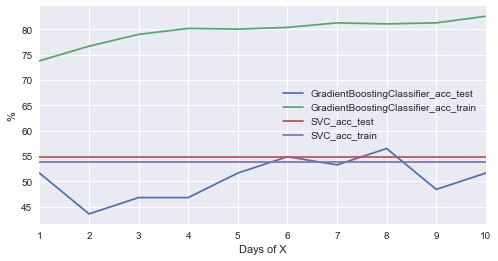

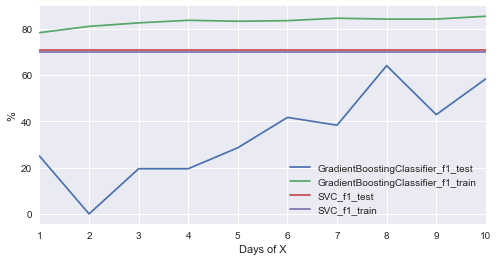

In [31]:
best_feature          = score_day(X = X, y = y, size = Page_size/2,
     feature_days_max = 10,
     feature          = feature_base)

----
## Improving Results

### Choosing the Best Model

**GradientBoostingClassifier** is the best model of the three models because of the **best F score, predicting time** and **good training time**. The algorithm is also suitable to handle the **mixed type of data** (heterogeneous features, Ref.: [`sklearn/modules/gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)).

The **Ensemble (Gradient Tree Boosting)** is based on the
**Tree**s which are composed of many feature-evaluation flows to prediction the income of every individual. For each individual, each tree starts from a specified feature-evaluation, e.g., age, to select the next branched feature-evaluations. After a sequence of sophisticated feature classification, the individual is classified to a predicted income class by a tree. 
The **Gradient** means: the feature selections, orders, and evaluation criteria of trees are tuned based on the prediction trend of the large data calculated by the calculus. 
The **Boosting** means: when tuning the trees, the false-predicted data will be weighted high to improve the weakness. 
The **Ensemble** means: The trees can vote as a team to perform better prediction than an individual. Each tree has different weaknesses and strengths because they grow and are tuned by arbitrary different data to try any better possibility.

### Implementation: Model Tuning

The best classifier is GradientBoostingClassifier with  77.92% f1-score and 14-day features per prediction


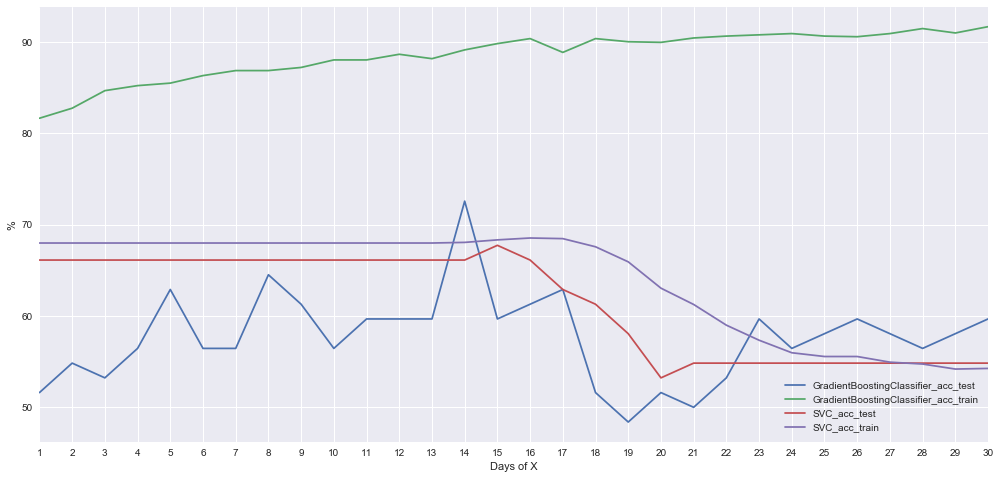

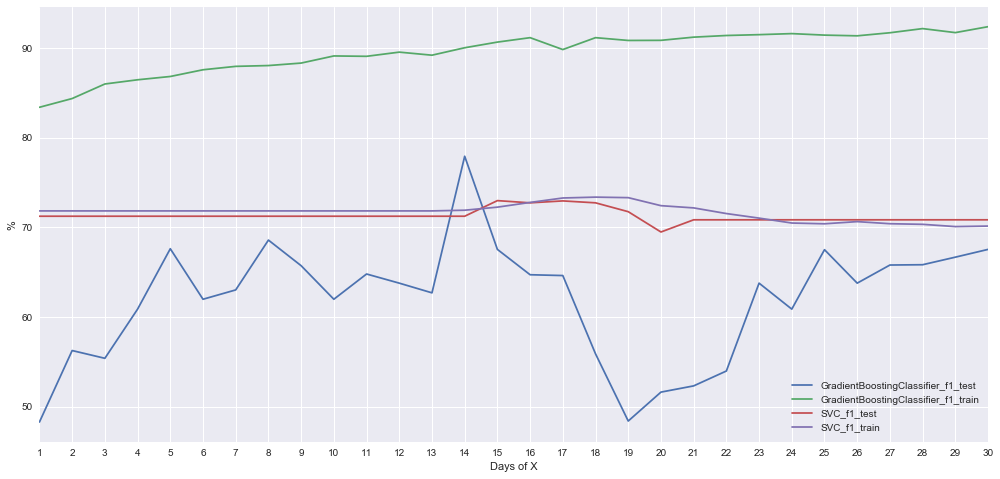

In [32]:
best_feature          = score_day(X = X, y = y,
     feature_days_max = 30,
     feature          = feature_base
                      + feature_vec
                      + feature_next
                      + feature_stat
                                 )

----
## Feature Importance

### Implementation - Extracting Feature Importance

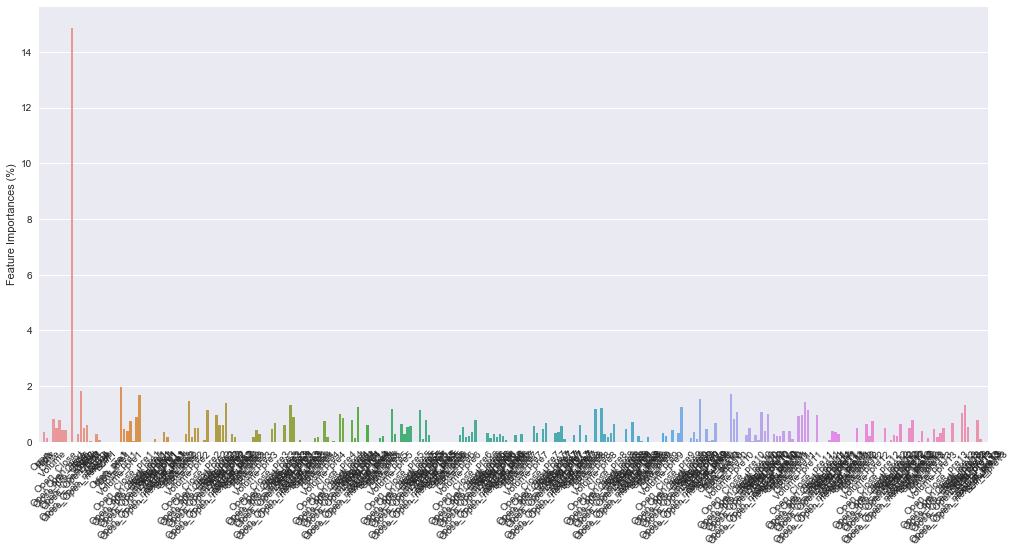

In [33]:
f = sns.barplot(best_feature['feature'],
                best_feature['clf'    ].feature_importances_*100,
                ax  = plt.subplots(figsize = (Page_size, Page_size/2))[1]);
f.set_xticklabels(f.get_xticklabels(), rotation = 45)
f.set_ylabel     ('Feature Importances (%)');

In [34]:
def        feature_importances(     feature, learner):
    df = pd.DataFrame         ({
       'Features'   :               feature,
       'Importances':                        learner.feature_importances_*100}).sort_values(by =
       'Importances', ascending = 0). reset_index(drop = 1).rename(index = lambda c: c + 1)
    df['Importances'] = df['Importances'].map(percent.format)
    return df

from sklearn.ensemble import GradientBoostingRegressor
def        feature_importances_GBR(X_train,               y_train, random_state = random_state, X_test = None, y_test = None):
    return feature_importances(    X_train.columns,
                               GradientBoostingRegressor         ( random_state = random_state).
                               fit(X_train,               y_train))

feature_importances_default = feature_importances(best_feature['feature'],
                                                  best_feature['clf'    ])

display(pd.concat([feature_importances_default,
                   feature_importances_GBR(**best_feature['Xy'])], axis = 1, keys = ['Classifier', 'Regressor']).head())

Classifier                         Regressor            
               Features Importances              Features Importances
1       Close_Open_next      14.87%       Close_Open_next      12.75%
2           Volume_pre1       1.95%              WR6_pre3       2.20%
3                  RSI6       1.81%                  RSI6       2.13%
4          Volume_pre10       1.71%           Volume_pre5       2.05%
5  Close_Open_next_pre1       1.66%  Close_Open_next_pre1       2.00%

### Feature Relevance Observation

The best classifier is GradientBoostingClassifier with  75.32% f1-score and 3-day features per prediction


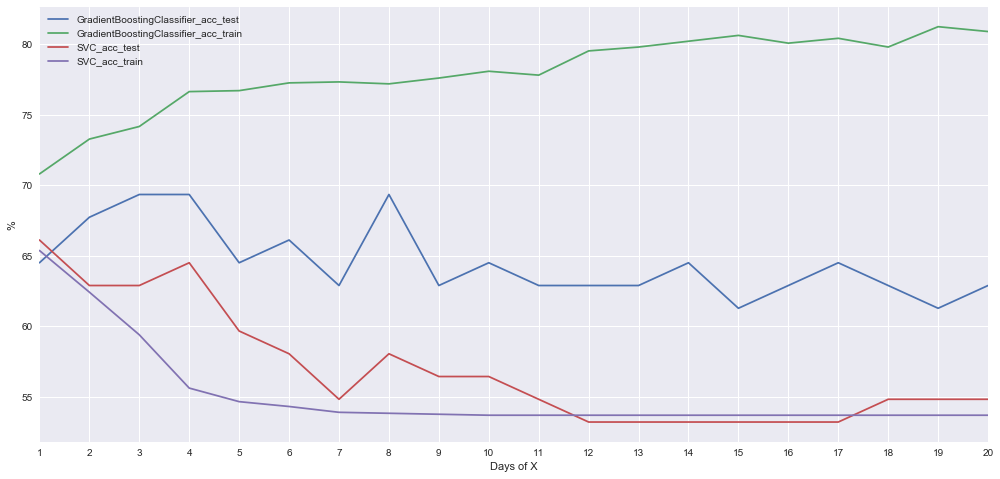

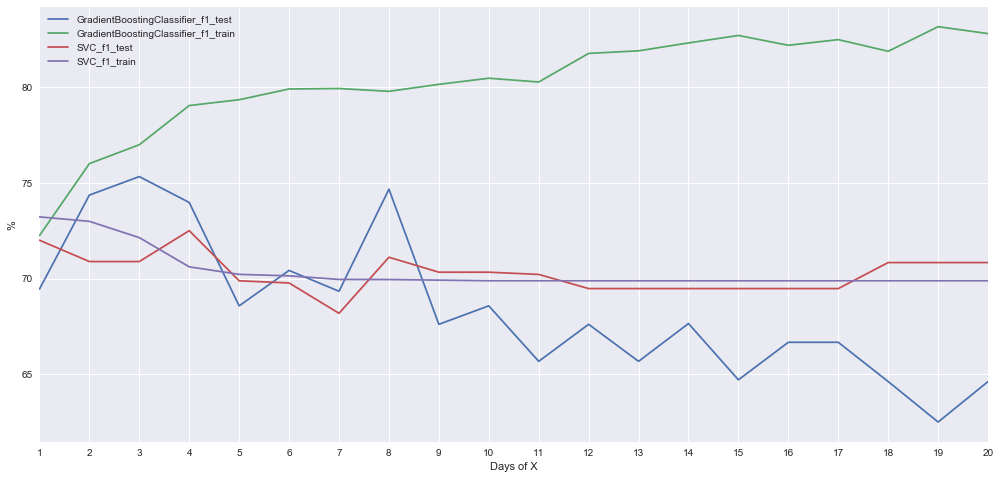

In [35]:
best_feature          = score_day(X = X, y = y,
     feature_days_max = 20,
     feature          = [
#                          'Open'              ,
#                          'High'              ,
#                          'Low'               ,
#                          'Close'             ,
#                          'Volume'            ,
#                          'Open_Close'        ,
#                          'Open_pre_Close'    ,
#                          'Close_pre_Close'   ,
#                          'Open_next'         ,
#                          'Open_Open_next'    ,
                         'Close_Open_next'   ,
#                          'Open_Open_next_up' ,
#                          'Close_Open_next_up',
#                          'RSI6'              ,
#                          'RSI12'             ,
#                          'WR6'               ,
#                          'WR10'              ,
#                          'C2M'               ,
#                          'MACD'              ,
#                          'Boll_u'            ,
#                          'Boll'              ,
#                          'Boll_l'            ,
                         ])

In [36]:
feature_importances_default = feature_importances(best_feature['feature'],
                                                  best_feature['clf'    ])
display(feature_importances_default.head())

,Features,Importances
1,Close_Open_next,42.86%
2,Close_Open_next_pre2,28.94%
3,Close_Open_next_pre1,28.20%


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline        import Pipeline

# scaler     = MinMaxScaler()
# clf        = SVC         ()
clf        = GradientBoostingClassifier(random_state = random_state, warm_start = True)

def clfTimeGrid(         clf , parameters,
                                  X_train, y_train,                         X_test, y_test,
                                                                                    n_splits = 3               , beta = beta):
    print 'Parameter Grid:'
    display(pd.DataFrame.from_dict(parameters, orient = 'index', dtype = object).T.fillna('').rename(index = lambda c: c + 1))
#     pipe               = Pipeline(steps=[('scaler', scaler), ('clf', clf)])
#     grid               = GridSearchCV(clf, parameters, scoring = 'roc_auc'      (   fbeta_score              , beta = beta),
    grid               = GridSearchCV(clf, parameters, scoring = make_scorer    (   fbeta_score                , beta = beta),
                                                       cv      = TimeSeriesSplit(   n_splits = n_splits) .split(X_train))
    predict_train      = clf .fit(X_train, y_train)                .predict(X_train)
    predict_test       = clf                                       .predict(X_test )
    estimator          = grid.fit(X_train, y_train).best_estimator_
    predict_best_train =                                 estimator .predict(X_train)
    predict_best_test  =                                 estimator .predict(X_test )

    display(concat([pd.DataFrame(OrderedDict([
      ('Train Accuracy'                   ,  [               accuracy_score(        y_train, predict_train                  )  ,
                                                             accuracy_score(        y_train, predict_best_train             )]),
      ( 'Test Accuracy'                   ,  [               accuracy_score(        y_test , predict_test                   )  ,
                                                             accuracy_score(        y_test , predict_best_test              )]),
      ('Train {}'.format('F-' + str(beta)),  [                  fbeta_score(        y_train, predict_train     , beta = beta)  ,
                                                                fbeta_score(        y_train, predict_best_train, beta = beta)]),
      ( 'Test {}'.format('F-' + str(beta)),  [                  fbeta_score(        y_test , predict_test      , beta = beta)  ,
                                                                fbeta_score(        y_test , predict_best_test , beta = beta)]),
                                 ])).applymap(lambda s: '{:.2f}%'.format(100*s)),
         pd.concat([pd.DataFrame( clf. get_params(), index = [0])[parameters.keys()],
                    pd.DataFrame(grid.best_params_ , index = [1])[parameters.keys()]])])
                                             .rename(index = {0:   'Default Model',
                                                              1: 'Optimized Model'}))
    return grid, feature_importances(X_train.columns, grid.best_estimator_)

In [38]:
clf        = GradientBoostingClassifier(random_state = random_state, warm_start = True)

parameters = OrderedDict([
    ('learning_rate'    ,
    [
#         0.2             ,
        0.1             ,
#         0.05            ,
    ]                  ),
    ('n_estimators'     ,
#      range             (
#          20             ,
#          81             ,
#          10
#                        )+
    [
#       100               ,
       70               ,
#        40               ,
    ]                  ),
    ('max_depth'        ,
#      range             (
#         5               ,
#         8               ,
#         9               ,
#        10               ,
#        11               ,
#        17               ,
#                        )+
    [
#        8                ,
       6                ,
#        5                ,
#        3                ,
    ]                  ),
    ('min_samples_split',
     range             (
#         4               ,
#         6               , # 0.5*len(y)
#         7               ,
#         8               ,
#        10               ,
       11               ,
#        13               , #     len(y)
       15               ,
                       )+
    [                   
#        2                ,
#        5                ,
#        6                ,
#       10                ,
    ]                  ),
    ('min_samples_leaf' ,
#      range             (
# #         1               ,
# #         4               ,
#         6               ,
#        11               ,
# #        12               ,
# #        14 
#                        )+
    [
#         1               ,
#         4               ,
#         5               ,
       10               ,
    ]                  ),
    ('max_features'     ,
    [
#         None            ,
#         0.4             ,
#         0.3             ,
        'sqrt'          ,
    ]                  ),
    ('subsample'        ,
    [
        0.8             ,
#         0.9             ,
#         1               ,
    ]                  ),
    ]                  )
# parameters = OrderedDict([
#     ('learning_rate'    , [        0.1   ,    ]        ),
#     ('n_estimators'     , [      100     ,    ]        ),
#     ('max_depth'        , [        3     ,    ]        ),
#     ('min_samples_split', [        2     ,    ]        ),
#     ('min_samples_leaf' , [        1     ,    ]        ),
#     ])
# parameters = [{'kernel': ['rbf'   ], 'C': [1, 10, 100, 1000], 'gamma': [1e-3, 1e-4]},
#               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]                       }]

grid, importances = clfTimeGrid(clf, parameters, **best_feature['Xy'])
display(pd.concat([feature_importances_default, importances], axis = 1, keys = ['Default', 'Optimized']).head())

Parameter Grid:


,learning_rate,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,subsample
1,0.1,70,6,11,10,sqrt,0.8
2,,,,12,,,
3,,,,13,,,
4,,,,14,,,


,Train Accuracy,Test Accuracy,Train F-1,Test F-1,learning_rate,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,subsample
Default Model,74.18%,69.35%,76.99%,75.32%,0.1,100,3,2,1,None,1.0
Optimized Model,82.35%,64.52%,83.99%,69.44%,0.1,70,6,11,10,sqrt,0.8


Default                         Optimized            
               Features Importances              Features Importances
1       Close_Open_next      42.86%       Close_Open_next      43.65%
2  Close_Open_next_pre2      28.94%  Close_Open_next_pre1      28.19%
3  Close_Open_next_pre1      28.20%  Close_Open_next_pre2      28.16%

### Final Model Evaluation

Close_next Regression r2-Score:  74.61%
Close_next Up/Down Classification Accuracy Score by Regression:  54.84%
Close_next Up/Down Classification       F1-Score by Regression:  70.83%


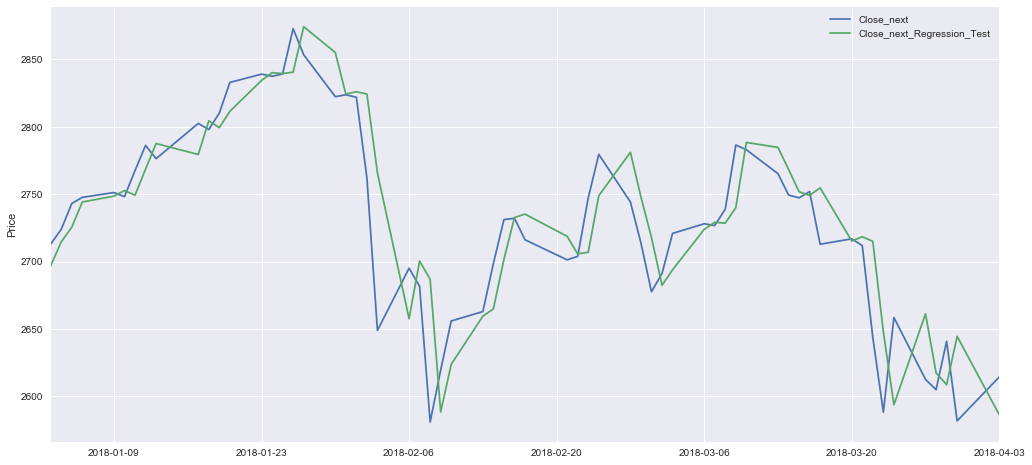

Open_next Regression r2-Score:  97.37%
Open_next Up/Down Classification Accuracy Score by Regression:  82.26%
Open_next Up/Down Classification       F1-Score by Regression:  83.58%


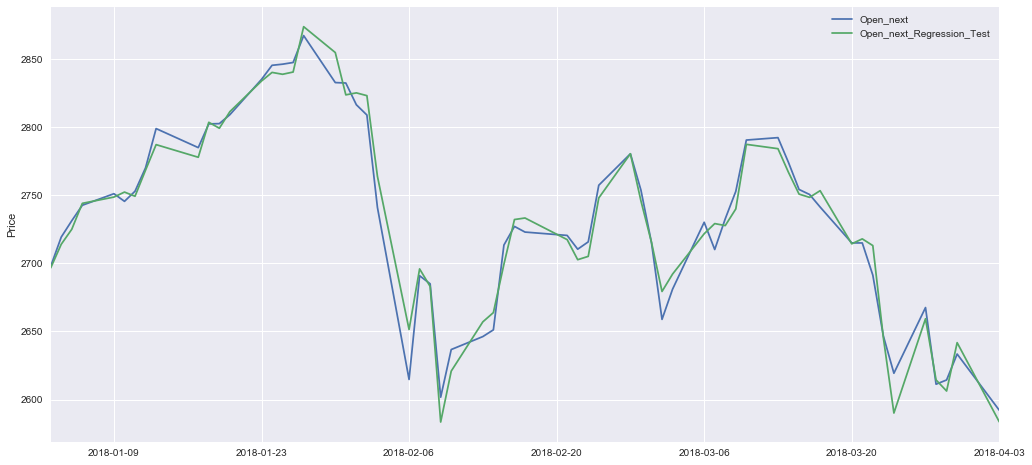

In [39]:
labels          =  ['Close_next', 'Open_next']

from sklearn.metrics import           r2_score

data_train,       data_test = Split1(data_log[day_range_Max - 1:], date_split)
for label in labels:
    y_train_raw = data_train[[label]]
    y_test_raw  = data_test [[label]]
    scaler_y    =        MinMaxScaler().fit            (                                                  y_train_raw )
    regressor   =    LinearRegression().fit            (X_train[feature_base], scaler_y.        transform(y_train_raw))
    predict     =          regressor   .       predict (X_test [feature_base])
    predict_raw =                                                              scaler_y.inverse_transform(
                                               predict                                                   )
    regression  = y_test_raw.copy()
    regression[label +   '_Regression_Test'] = predict_raw
    classification = data_test[label.split('_')[0]] <= regression
    x           = label.split('_')[0]
    acc, f1     = clf_scores(data_test[                  x        ] <= regression.iloc[:, -1],
                             data_test['{}_{}_up'.format(x, label)]                          , beta)
    print              '{} Regression r2-Score: {:6.2f}%'                    .format (label, 100*
                                      r2_score(predict                       , scaler_y.        transform(y_test_raw )))
    print  '{} Up/Down Classification Accuracy Score by Regression: {:6.2f}%'.format (label, 100* acc)
    print  '{} Up/Down Classification       F1-Score by Regression: {:6.2f}%'.format (label, 100*  f1)
    ax = regression.plot( figsize = (Page_size, Page_size/2));
    ax .    set_ylabel  ('Price')
    plt.show()

The best classifier is GradientBoostingClassifier with  79.49% f1-score and 13-day features per prediction


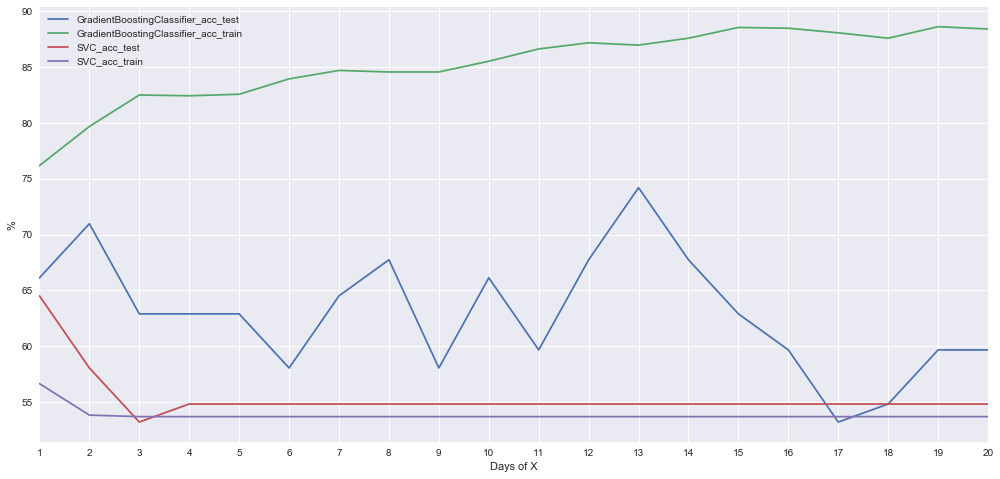

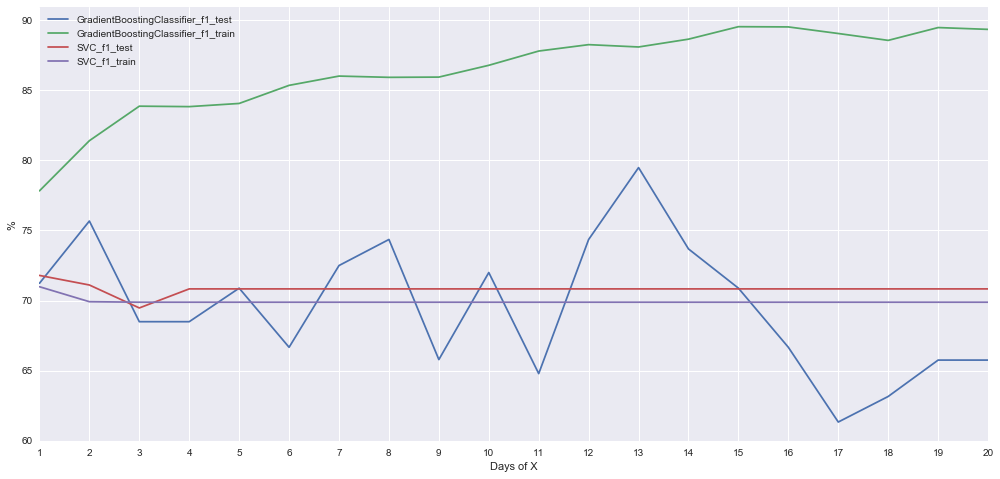

In [ ]:
best_feature          = score_day(X = X, y = y,
     feature_days_max = 20,
     feature          = [
#                          'Open'              ,
#                          'High'              ,
#                          'Low'               ,
#                          'Close'             ,
#                          'Volume'            ,
#                          'Open_Close'        ,
                         'Open_pre_Close'    ,
                         'Close_pre_Close'   ,
#                          'Open_next'         ,
#                          'Open_Open_next'    ,
                         'Close_Open_next'   ,
#                          'Open_Open_next_up' ,
#                          'Close_Open_next_up',
#                          'RSI6'              ,
#                          'RSI12'             ,
                         'WR6'               ,
#                          'WR10'              ,
#                          'C2M'               ,
#                          'MACD'              ,
#                          'Boll_u'            ,
#                          'Boll'              ,
#                          'Boll_l'            ,
                         ])

In [ ]:
feature_days_max =  14
feature_must     = [
                    'Close_Open_next'   ,
                   ]
features         = [
#                     'Open'              ,
#                     'High'              ,
#                     'Low'               ,
                    'Volume'            ,
#                     'Close'             ,
                    'Open_pre_Close'    ,
                    'Close_pre_Close'   ,
                    'Open_Close'        ,
                    'Open_next'         ,
                    'Close_Open_next'   ,
                    'Open_Open_next'    ,
                    'Open_Open_next_up' ,
                    'Close_Open_next_up',
                    'RSI6'              ,
                    'RSI12'             ,
                    'WR6'               ,
                    'WR10'              ,
#                     'C2M'               ,
                    'MACD'              ,
#                     'Boll_u'            ,
#                     'Boll'              ,
#                     'Boll_l'            ,
                   ]

from itertools import combinations
csv         = lambda l: ','.join(l)
top         = {fbeta: 0}
top_feature = feature_must
for n in range(1, 1   +                    len(features)   ):
    for feature in [feature_must] + map(list, combinations(features, n)):
        cur                    =  score_day(output = 0,
            feature_days_max   =          feature_days_max,
            feature            = list(set(feature_must + feature)))
        if  top[fbeta]         <      cur[fbeta]:
            top                =      cur
            top_feature        =          feature
        print 'Best: {:.2f}% {}x{} Cur: {:.2f}%: {}x{}'.format(100*top[fbeta], top['days'], csv(top_feature),
                                                               100*cur[fbeta], cur['days'], csv(    feature))                 

Best: 75.32% 3xClose_Open_next Cur: 75.32%: 3xClose_Open_next
Best: 75.32% 3xClose_Open_next Cur: 75.00%: 14xVolume
Best: 75.32% 3xClose_Open_next Cur: 75.32%: 2xOpen_pre_Close
Best: 75.32% 3xClose_Open_next Cur: 75.32%: 13xClose_pre_Close
Best: 75.32% 3xClose_Open_next Cur: 74.36%: 12xOpen_Close
Best: 75.32% 3xClose_Open_next Cur: 72.50%: 3xOpen_next
Best: 75.32% 3xClose_Open_next Cur: 75.32%: 3xClose_Open_next
Best: 75.32% 3xClose_Open_next Cur: 74.07%: 2xOpen_Open_next
Best: 75.32% 3xClose_Open_next Cur: 75.00%: 7xOpen_Open_next_up
Best: 75.32% 3xClose_Open_next Cur: 75.32%: 3xClose_Open_next_up
Best: 75.32% 3xClose_Open_next Cur: 73.68%: 5xRSI6
Best: 75.32% 3xClose_Open_next Cur: 73.97%: 14xRSI12
Best: 75.68% 8xWR6 Cur: 75.68%: 8xWR6
Best: 75.68% 8xWR6 Cur: 75.00%: 13xWR10
Best: 75.68% 8xWR6 Cur: 74.42%: 3xMACD
Best: 75.68% 8xWR6 Cur: 75.32%: 3xClose_Open_next
Best: 75.68% 8xWR6 Cur: 75.00%: 8xVolume,Open_pre_Close
Best: 75.68% 8xWR6 Cur: 74.36%: 4xVolume,Close_pre_Close
Best: 75.6

Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 76.71%: 8xVolume,Open_pre_Close,Close_Open_next_up
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 74.29%: 13xVolume,Open_pre_Close,RSI6
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 72.50%: 1xVolume,Open_pre_Close,RSI12
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 73.97%: 1xVolume,Open_pre_Close,WR6
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 76.32%: 1xVolume,Open_pre_Close,WR10
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 72.50%: 1xVolume,Open_pre_Close,MACD
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 74.36%: 14xVolume,Close_pre_Close,Open_Close
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 73.24%: 12xVolume,Close_pre_Close,Open_next
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 74.36%: 4xVolume,Close_pre_Close,Close_Open_next
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 75.32%: 14xVolume,Close_pre_Close,Open_Open_next
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 73.42%: 1xVolume,Close_pre_Close,Open_Open_next_up
Best: 77.92% 7xOpen_Open_next_up,WR10 Cur: 71.23%: 1

Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 72.00%: 1xOpen_pre_Close,Open_next,Open_Open_next
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.79%: 1xOpen_pre_Close,Open_next,Open_Open_next_up
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 73.53%: 13xOpen_pre_Close,Open_next,Close_Open_next_up
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.11%: 3xOpen_pre_Close,Open_next,RSI6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 70.83%: 5xOpen_pre_Close,Open_next,RSI12
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 72.22%: 13xOpen_pre_Close,Open_next,WR6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.74%: 3xOpen_pre_Close,Open_next,WR10
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.11%: 3xOpen_pre_Close,Open_next,MACD
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 73.68%: 2xOpen_pre_Close,Close_Open_next,Open_Open_next
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 74.36%: 3xOpen_pre_Close,

Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 72.73%: 2xClose_pre_Close,Open_Open_next_up,RSI12
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 72.97%: 1xClose_pre_Close,Open_Open_next_up,WR6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 74.42%: 2xClose_pre_Close,Open_Open_next_up,WR10
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 73.42%: 1xClose_pre_Close,Open_Open_next_up,MACD
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 73.68%: 2xClose_pre_Close,Close_Open_next_up,RSI6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.23%: 1xClose_pre_Close,Close_Open_next_up,RSI12
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 72.97%: 1xClose_pre_Close,Close_Open_next_up,WR6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 74.36%: 12xClose_pre_Close,Close_Open_next_up,WR10
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.23%: 1xClose_pre_Close,Close_Open_next_up,MACD
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR

Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 73.33%: 3xOpen_next,Open_Open_next_up,WR10
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.91%: 2xOpen_next,Open_Open_next_up,MACD
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 75.00%: 12xOpen_next,Close_Open_next_up,RSI6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.23%: 1xOpen_next,Close_Open_next_up,RSI12
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.23%: 1xOpen_next,Close_Open_next_up,WR6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.23%: 1xOpen_next,Close_Open_next_up,WR10
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.23%: 1xOpen_next,Close_Open_next_up,MACD
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 72.22%: 14xOpen_next,RSI6,RSI12
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 71.74%: 3xOpen_next,RSI6,WR6
Best: 78.48% 13xOpen_pre_Close,Close_pre_Close,WR6 Cur: 75.68%: 12xOpen_next,RSI6,WR10
Best: 78.48% 13xOpen_pre_Close,Close_pre_

Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 71.23%: 1xClose_Open_next_up,RSI12,WR6
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 74.67%: 8xClose_Open_next_up,RSI12,WR10
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 71.23%: 1xClose_Open_next_up,RSI12,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 74.67%: 1xClose_Open_next_up,WR6,WR10
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 71.23%: 1xClose_Open_next_up,WR6,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 71.23%: 1xClose_Open_next_up,WR10,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.50%: 1xRSI6,RSI12,WR6
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 75.00%: 12xRSI6,RSI12,WR10
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 75.36%: 14xRSI6,RSI12,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 74.67%: 11xRSI6,WR6,WR10
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.50%: 1xRSI6,WR6,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.85%: 12xRSI6,WR10,MACD
Best: 78.95% 12xOpen_Open_next_up,RS

Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.50%: 1xVolume,Close_pre_Close,Open_Close,Open_Open_next
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 76.32%: 14xVolume,Close_pre_Close,Open_Close,Open_Open_next_up
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.22%: 1xVolume,Close_pre_Close,Open_Close,Close_Open_next_up
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 74.67%: 12xVolume,Close_pre_Close,Open_Close,RSI6
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.68%: 13xVolume,Close_pre_Close,Open_Close,RSI12
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.73%: 10xVolume,Close_pre_Close,Open_Close,WR6
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.68%: 14xVolume,Close_pre_Close,Open_Close,WR10
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.42%: 1xVolume,Close_pre_Close,Open_Close,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.24%: 12xVolume,Close_pre_Close,Open_next,Close_Open_next
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.68%: 12xVolume,Close_pr

Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 74.67%: 1xVolume,Open_Close,Open_Open_next_up,WR10
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.50%: 1xVolume,Open_Close,Open_Open_next_up,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.97%: 8xVolume,Open_Close,Close_Open_next_up,RSI6
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 71.23%: 1xVolume,Open_Close,Close_Open_next_up,RSI12
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.68%: 1xVolume,Open_Close,Close_Open_next_up,WR6
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 73.68%: 14xVolume,Open_Close,Close_Open_next_up,WR10
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 71.23%: 1xVolume,Open_Close,Close_Open_next_up,MACD
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.73%: 6xVolume,Open_Close,RSI6,RSI12
Best: 78.95% 12xOpen_Open_next_up,RSI6,WR6 Cur: 72.97%: 1xVolume,Open_Close,RSI6,WR6
